In [ ]:
### -------------------------------------- IMPORTANT NOTE --------------------------------------------------
### Running the whole notebook will take around 5-6 hours (WITHOUT training).
### Notebook will NOT run in Colab as I am using Stellar Graphs Library.

# Knowledge Graph Completion

A **knowledge graph** (KG) is a structured representation of information, where entities are nodes, and relationships between entities are edges. Knowledge Graph Completion involves predicting missing relationships or edges in a knowledge graph.

For this project, we will be experimenting with **Freebase dataset**. Freebase is an extensive, openly available knowledge graph that captures diverse information about entities, their attributes, and relationships. Google's Knowledge Graph is powered in part by Freebase. Image below shows some well-know knowledge graphs.

<img src="https://media.licdn.com/dms/image/C4E12AQGDG1c_A6bWkQ/article-cover_image-shrink_600_2000/0/1582640385447?e=1706140800&v=beta&t=JSWH1UPgNmN-KSX0_f-nfV-SjAXv1h5xHKiGSEXCXB0" width="700" height="500">

## 1. Requirement Installation and Importing libraries

In [ ]:
%%capture
# Install Tensorflow GPU
! pip install tensorflow-gpu==1.15.3

In [ ]:
from stellargraph import datasets, utils
import numpy as np
import pandas as pd
from stellargraph.mapper import KGTripleGenerator
from stellargraph.layer import ComplEx
import networkx as nx
from IPython.display import HTML

In [ ]:
import tensorflow as tf
from tensorflow.keras import callbacks, optimizers, losses, metrics, regularizers, Model
print('TensorFlow  version: {}'.format(tf.__version__))

TensorFlow  version: 1.15.3


In [ ]:
%%capture
# Install AmpliGraph library
! pip install ampligraph

# Required to visualize embeddings with tensorboard projector, comment out if not required!
! pip install --user tensorboard

# Required to plot text on embedding clusters, comment out if not required!
! pip install --user git+https://github.com/Phlya/adjustText

In [ ]:
import ampligraph
from ampligraph.datasets import load_fb15k_237
from ampligraph.evaluation import train_test_split_no_unseen, evaluate_performance, mr_score, mrr_score, hits_at_n_score
from ampligraph.discovery import query_topn, discover_facts, find_clusters
from ampligraph.latent_features import TransE, ComplEx, HolE, DistMult, ConvE, ConvKB
from ampligraph.utils import save_model, restore_model

In [ ]:
def display_aggregate_metrics(ranks):
    print('Mean Rank:', mr_score(ranks))
    print('Mean Reciprocal Rank:', mrr_score(ranks))
    print('Hits@1:', hits_at_n_score(ranks, 1))
    print('Hits@10:', hits_at_n_score(ranks, 10))
    print('Hits@100:', hits_at_n_score(ranks, 100))

print('Ampligraph version: {}'.format(ampligraph.__version__))

Ampligraph version: 1.4.0


If you see these versions, you are good to go!

TensorFlow  version: 1.15.3

Ampligraph version: 1.4.0

## 2. Loading the Freebase KG dataset

In [ ]:
FB15k_237 = datasets.FB15k_237()
display(HTML(FB15k_237.description))

In [ ]:
FB15k_237.expected_files

['train.txt', 'test.txt', 'valid.txt']

In [ ]:
graph, trainSet, testSet, validSet = FB15k_237.load()

In [ ]:
trainSet.head

<bound method NDFrame.head of             source                                              label  \
0         /m/027rn               /location/country/form_of_government   
1        /m/017dcd  /tv/tv_program/regular_cast./tv/regular_tv_app...   
2       /m/07s9rl0                 /media_common/netflix_genre/titles   
3        /m/01sl1q  /award/award_winner/awards_won./award/award_ho...   
4        /m/0cnk2q  /soccer/football_team/current_roster./sports/s...   
...            ...                                                ...   
272110   /m/016mhd  /film/film/release_date_s./film/film_regional_...   
272111   /m/01g888                               /music/genre/artists   
272112   /m/0djvzd  /soccer/football_player/current_team./sports/s...   
272113  /m/0gmblvq  /award/award_winning_work/awards_won./award/aw...   
272114   /m/020jqv  /award/award_nominee/award_nominations./award/...   

            target  
0         /m/06cx9  
1        /m/06v8s0  
2        /m/0170z3  
3        

In [ ]:
testSet.head(5)

,source,label,target
0,/m/08966,/travel/travel_destination/climate./travel/tra...,/m/05lf_
1,/m/01hww_,/music/performance_role/regular_performances./...,/m/01q99h
2,/m/09v3jyg,/film/film/release_date_s./film/film_regional_...,/m/0f8l9c
3,/m/02jx1,/location/location/contains,/m/013t85
4,/m/02jx1,/location/location/contains,/m/0m0bj


In [ ]:
validSet.head

<bound method NDFrame.head of            source                                              label  \
0       /m/07pd_j                                   /film/film/genre   
1        /m/06wxw                      /location/location/time_zones   
2      /m/01t94_1  /people/person/spouse_s./people/marriage/type_...   
3      /m/02xcb6n  /award/award_category/winners./award/award_hon...   
4       /m/07f_7h  /film/film/release_date_s./film/film_regional_...   
...           ...                                                ...   
17530  /m/02x4x18  /award/award_category/nominees./award/award_no...   
17531    /m/0bw20  /film/film/other_crew./film/film_crew_gig/film...   
17532   /m/01j4ls     /common/topic/webpage./common/webpage/category   
17533  /m/0cmdwwg  /film/film/release_date_s./film/film_regional_...   
17534   /m/0gs6vr            /film/actor/film./film/performance/film   

           target  
0       /m/02l7c8  
1       /m/02fqwt  
2        /m/04ztj  
3       /m/04x4s2  
4    

![KG](https://user-images.githubusercontent.com/39597669/90747195-9fc44c80-e2c8-11ea-9f70-097993581bac.png)
[Image Reference](https://kge-tutorial-ecai2020.github.io/ECAI-20_KGE_tutorial.pdf)

For this project, we will be using a different version of freebase-237 with remapped IDs and containing human readable names instead of IDs using the following [JSON](https://raw.githubusercontent.com/villmow/datasets_knowledge_embedding/master/FB15k-237/entity2wikidata.json) file.

In [ ]:
URL = 'https://ampgraphenc.s3-eu-west-1.amazonaws.com/datasets/freebase-237-merged-and-remapped.csv'
dataset = pd.read_csv(URL, header=None)
dataset.columns = ['subject', 'predicate', 'object']
dataset.head(5)

,subject,predicate,object
0,"queens college, city university of new york",/education/educational_institution/students_gr...,carol leifer
1,digital equipment corporation,/business/business_operation/industry,computer hardware
2,/m/0drtv8,/award/award_ceremony/awards_presented./award/...,laurence mark
3,the departed,/award/award_winning_work/awards_won./award/aw...,leonardo dicaprio
4,marilyn manson,/people/person/profession,actor


## 3. KG visualization

In [ ]:
dataset.shape

(310079, 3)

In [ ]:
## Shuffling the Dataset
dataset = dataset.sample(frac = 1)

In [ ]:
## Reduce the number of nodes and edges for
dataset_1 = dataset.sample(frac=0.0001)

### Converting to NetworkX Graph for visualization

In [ ]:
## Create a directed graph
fb15kGraph = nx.DiGraph()
fb15kGraph.clear()
edge_labels ={}
for _, row in dataset_1.iterrows():
    tail = row['subject']
    head = row['object']
    edge = row['predicate'][-15:]
    fb15kGraph.add_edge(tail, head, length = 10)
    edge_labels[tail,head] = edge

### Spring Layout Visualization

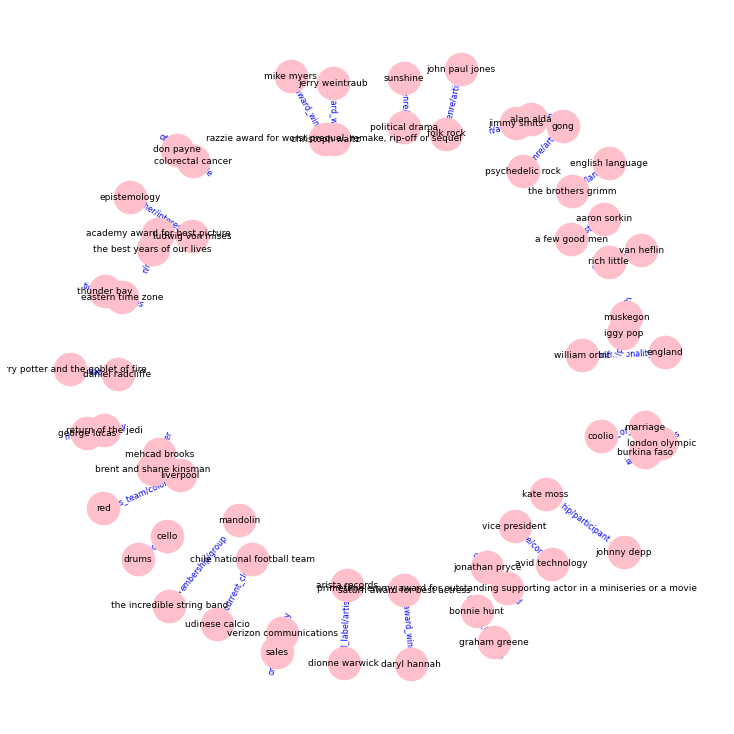

In [ ]:
## plotting the graph
from matplotlib import pyplot as plt
plt.figure(figsize=(10, 10))
options = {"node_color": "pink", "node_size": 1000, "linewidths": 2, "width": 0.1}

pos = nx.spring_layout(fb15kGraph, seed=1969)  # Seed for reproducible layout
nx.draw(fb15kGraph, pos, **options, with_labels=True, font_size = 9)


nx.draw_networkx_edge_labels(
    fb15kGraph, pos,
    edge_labels,
    font_size = 8,
    font_color='blue'
)

plt.show()

### Random Layout Visualization

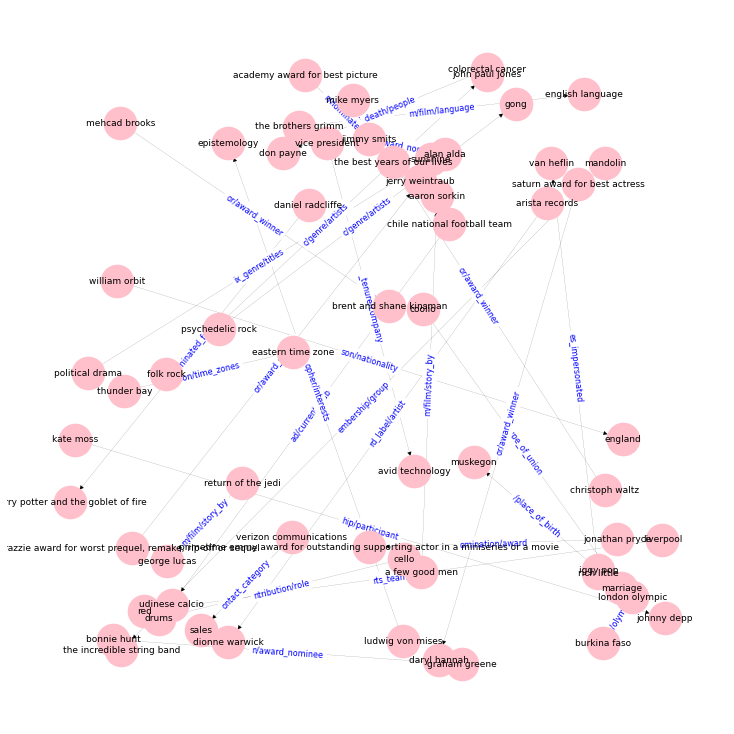

In [ ]:
## plotting the graph
from matplotlib import pyplot as plt
plt.figure(figsize=(10, 10))
options = {"node_color": "pink", "node_size": 1000, "linewidths": 2, "width": 0.1}

pos = nx.random_layout(fb15kGraph, seed=1969)  # Seed for reproducible layout
nx.draw(fb15kGraph, pos, **options, with_labels=True, font_size = 9)


nx.draw_networkx_edge_labels(
    fb15kGraph, pos,
    edge_labels,
    font_size = 8,
    font_color='blue'
)

plt.show()

## 4. Create Training, Validation and Test splits

We are using the ['train_test_split_no_unseen'](https://docs.ampligraph.org/en/1.3.1/generated/ampligraph.evaluation.train_test_split_no_unseen.html?#train-test-split-no-unseen) function provided by Ampligraph to create the training, validation and test splits. This API ensures that the test and validation splits contains triples whose entities are "seen" during training. `train_test_split_no_unseen` API can be used to generate train/test splits such that test set contains only entities 'seen' during training

We are splitting the dataset into this ratio: Train:Valid:Test <=> 80:10:10

[Code Refered from this notebook](https://kge-tutorial-ecai2020.github.io/)


In [ ]:
from ampligraph.evaluation import train_test_split_no_unseen

# get the validation set of size 31k
test_train, X_valid = train_test_split_no_unseen(dataset.values, 31000, seed=0)

# get the test set of size 31k from the remaining triples
X_train, X_test = train_test_split_no_unseen(test_train, 31000, seed=0)

print('Total triples:', dataset.shape)
print('Size of Training Set:', X_train.shape)
print('Size of Valid Set:', X_valid.shape)
print('Size of Test Set:', X_test.shape)

Total triples: (310079, 3)
Size of Training Set: (248079, 3)
Size of Valid Set: (31000, 3)
Size of Test Set: (31000, 3)


## 5. Model Training

In [ ]:
from ampligraph.latent_features import TransE
from ampligraph.utils import save_model, restore_model

###  Experiments with TransE

In [ ]:
## Epoch = 100
## ETA = 1
## Batch Count= 10

##------------------------------ UNCOMMENT TO TRAIN ---------------------------------------------------------------
# model = TransE(k=150,                                                         # embedding size
#                epochs=100,                                                        # Num of epochs
#                batches_count= 10,                                                 # Number of batches
#                eta=1,                                                             # number of corruptions to generate during training
#                loss='pairwise', loss_params={'margin': 1},                        # loss type and it's hyperparameters
#                initializer='xavier', initializer_params={'uniform': False},       # initializer type and it's hyperparameters
#                regularizer='LP', regularizer_params= {'lambda': 0.001, 'p': 3},   # regularizer along with its hyperparameters
#                optimizer= 'adam', optimizer_params= {'lr': 0.001},                # optimizer to use along with its hyperparameters
#                seed= 0, verbose=True)

# model.fit(X_train)
# save_model(model, 'TransE_100_1_10.pkl')

In [ ]:
model = restore_model('TransE_100_1_10.pkl')

# create the filter
X_filter = np.concatenate([X_train, X_valid, X_test], 0)

# compute ranks
ranks = evaluate_performance(X_test,
                             model=model,
                             filter_triples=X_filter)

# ranks are computed per triple
print('Test set:', X_test.shape)
print('Size of ranks:', ranks.shape)

# Aggregate metrics show the aggregate performance of the model on the test set using a single number
display_aggregate_metrics(ranks)

100%|██████████████████████████████████████████████████████| 31000/31000 [06:27<00:00, 79.98it/s]


Test set: (31000, 3)
Size of ranks: (31000, 2)
Mean Rank: 1003.9824838709677
Mean Reciprocal Rank: 0.13276623846469093
Hits@1: 0.07219354838709677
Hits@10: 0.2509516129032258
Hits@100: 0.5044354838709677


In [ ]:
## Epoch = 100
## ETA = 5
## Batch Count= 10

##------------------------------ UNCOMMENT TO TRAIN ---------------------------------------------------------------
# model = TransE(k=150,                                                         # embedding size
#                epochs=100,                                                        # Num of epochs
#                batches_count= 10,                                                 # Number of batches
#                eta=5,                                                             # number of corruptions to generate during training
#                loss='pairwise', loss_params={'margin': 1},                        # loss type and it's hyperparameters
#                initializer='xavier', initializer_params={'uniform': False},       # initializer type and it's hyperparameters
#                regularizer='LP', regularizer_params= {'lambda': 0.001, 'p': 1},   # regularizer along with its hyperparameters
#                optimizer= 'adam', optimizer_params= {'lr': 0.001},                # optimizer to use along with its hyperparameters
#                seed= 0, verbose=True)

# model.fit(X_train)
# save_model(model, 'TransE_100_5_10.pkl')

In [ ]:
model = restore_model('TransE_100_5_10.pkl')

# create the filter
X_filter = np.concatenate([X_train, X_valid, X_test], 0)

# compute ranks
ranks = evaluate_performance(X_test,
                             model=model,
                             filter_triples=X_filter)

# ranks are computed per triple
print('Test set:', X_test.shape)
print('Size of ranks:', ranks.shape)

# Aggregate metrics show the aggregate performance of the model on the test set using a single number
display_aggregate_metrics(ranks)

100%|██████████████████████████████████████████████████████| 31000/31000 [06:28<00:00, 79.80it/s]


Test set: (31000, 3)
Size of ranks: (31000, 2)
Mean Rank: 1223.5502096774194
Mean Reciprocal Rank: 0.14190764028313266
Hits@1: 0.08109677419354838
Hits@10: 0.25870967741935486
Hits@100: 0.49443548387096775


In [ ]:
## Epoch = 100
## ETA = 10
## Batch Count= 10

##------------------------------ UNCOMMENT TO TRAIN ---------------------------------------------------------------
# model = TransE(k=150,                                                         # embedding size
#                epochs=100,                                                        # Num of epochs
#                batches_count= 10,                                                 # Number of batches
#                eta=10,                                                             # number of corruptions to generate during training
#                loss='pairwise', loss_params={'margin': 1},                        # loss type and it's hyperparameters
#                initializer='xavier', initializer_params={'uniform': False},       # initializer type and it's hyperparameters
#                regularizer='LP', regularizer_params= {'lambda': 0.001, 'p': 1},   # regularizer along with its hyperparameters
#                optimizer= 'adam', optimizer_params= {'lr': 0.001},                # optimizer to use along with its hyperparameters
#                seed= 0, verbose=True)

# model.fit(X_train)
# save_model(model, 'TransE_100_10_10.pkl')

In [ ]:
bestModel_1 = restore_model('TransE_100_10_10.pkl')

# create the filter
X_filter = np.concatenate([X_train, X_valid, X_test], 0)

# compute ranks
ranks = evaluate_performance(X_test,
                             model=bestModel_1,
                             filter_triples=X_filter)

# ranks are computed per triple
print('Test set:', X_test.shape)
print('Size of ranks:', ranks.shape)

# Aggregate metrics show the aggregate performance of the model on the test set using a single number
display_aggregate_metrics(ranks)

100%|██████████████████████████████████████████████████████| 31000/31000 [06:02<00:00, 85.60it/s]


Test set: (31000, 3)
Size of ranks: (31000, 2)
Mean Rank: 1280.4652741935483
Mean Reciprocal Rank: 0.14320688641798027
Hits@1: 0.08304838709677419
Hits@10: 0.2595967741935484
Hits@100: 0.4910806451612903


In [ ]:
## Epoch = 200
## ETA = 1
## Batch Count= 10

##------------------------------ UNCOMMENT TO TRAIN ---------------------------------------------------------------
# model = TransE(k=150,                                                         # embedding size
#                epochs=200,                                                        # Num of epochs
#                batches_count= 10,                                                 # Number of batches
#                eta=1,                                                            # number of corruptions to generate during training
#                loss='pairwise', loss_params={'margin': 1},                        # loss type and it's hyperparameters
#                initializer='xavier', initializer_params={'uniform': False},       # initializer type and it's hyperparameters
#                regularizer='LP', regularizer_params= {'lambda': 0.001, 'p': 1},   # regularizer along with its hyperparameters
#                optimizer= 'adam', optimizer_params= {'lr': 0.001},                # optimizer to use along with its hyperparameters
#                seed= 0, verbose=True)

# model.fit(X_train)
# save_model(model, 'TransE_200_1_10.pkl')

In [ ]:
model = restore_model('TransE_200_1_10.pkl')

# create the filter
X_filter = np.concatenate([X_train, X_valid, X_test], 0)

# compute ranks
ranks = evaluate_performance(X_test,
                             model=model,
                             filter_triples=X_filter)

# ranks are computed per triple
print('Test set:', X_test.shape)
print('Size of ranks:', ranks.shape)

# Aggregate metrics show the aggregate performance of the model on the test set using a single number
display_aggregate_metrics(ranks)

100%|██████████████████████████████████████████████████████| 31000/31000 [05:58<00:00, 86.37it/s]


Test set: (31000, 3)
Size of ranks: (31000, 2)
Mean Rank: 1268.1801129032258
Mean Reciprocal Rank: 0.12631901602732196
Hits@1: 0.06912903225806452
Hits@10: 0.23603225806451614
Hits@100: 0.46558064516129033


In [ ]:
## Epoch = 200
## ETA = 5
## Batch Count= 10

##------------------------------ UNCOMMENT TO TRAIN ---------------------------------------------------------------
# model = TransE(k=150,                                                         # embedding size
#                epochs=200,                                                        # Num of epochs
#                batches_count= 10,                                                 # Number of batches
#                eta=5,                                                            # number of corruptions to generate during training
#                loss='pairwise', loss_params={'margin': 1},                        # loss type and it's hyperparameters
#                initializer='xavier', initializer_params={'uniform': False},       # initializer type and it's hyperparameters
#                regularizer='LP', regularizer_params= {'lambda': 0.001, 'p': 1},   # regularizer along with its hyperparameters
#                optimizer= 'adam', optimizer_params= {'lr': 0.001},                # optimizer to use along with its hyperparameters
#                seed= 0, verbose=True)

# model.fit(X_train)
# save_model(model, 'TransE_200_5_10.pkl')

In [ ]:
model = restore_model('TransE_200_5_10.pkl')

# create the filter
X_filter = np.concatenate([X_train, X_valid, X_test], 0)

# compute ranks
ranks = evaluate_performance(X_test,
                             model=model,
                             filter_triples=X_filter)

# ranks are computed per triple
print('Test set:', X_test.shape)
print('Size of ranks:', ranks.shape)

# Aggregate metrics show the aggregate performance of the model on the test set using a single number
display_aggregate_metrics(ranks)

100%|██████████████████████████████████████████████████████| 31000/31000 [06:09<00:00, 83.90it/s]


Test set: (31000, 3)
Size of ranks: (31000, 2)
Mean Rank: 1610.2811451612904
Mean Reciprocal Rank: 0.1329906124502318
Hits@1: 0.07656451612903226
Hits@10: 0.24017741935483872
Hits@100: 0.43925806451612903


In [ ]:
## Epoch = 200
## ETA = 10
## Batch Count= 10

##------------------------------ UNCOMMENT TO TRAIN ---------------------------------------------------------------
# model = TransE(k=150,                                                         # embedding size
#                epochs=200,                                                        # Num of epochs
#                batches_count= 10,                                                 # Number of batches
#                eta=10,                                                            # number of corruptions to generate during training
#                loss='pairwise', loss_params={'margin': 1},                        # loss type and it's hyperparameters
#                initializer='xavier', initializer_params={'uniform': False},       # initializer type and it's hyperparameters
#                regularizer='LP', regularizer_params= {'lambda': 0.001, 'p': 1},   # regularizer along with its hyperparameters
#                optimizer= 'adam', optimizer_params= {'lr': 0.001},                # optimizer to use along with its hyperparameters
#                seed= 0, verbose=True)

# model.fit(X_train)
# save_model(model, 'TransE_200_10_10.pkl')

In [ ]:
model = restore_model('TransE_200_10_10.pkl')

# create the filter
X_filter = np.concatenate([X_train, X_valid, X_test], 0)

# compute ranks
ranks = evaluate_performance(X_test,
                             model=model,
                             filter_triples=X_filter)

# ranks are computed per triple
print('Test set:', X_test.shape)
print('Size of ranks:', ranks.shape)

# Aggregate metrics show the aggregate performance of the model on the test set using a single number
display_aggregate_metrics(ranks)

100%|██████████████████████████████████████████████████████| 31000/31000 [08:25<00:00, 61.31it/s]


Test set: (31000, 3)
Size of ranks: (31000, 2)
Mean Rank: 1683.9729838709677
Mean Reciprocal Rank: 0.13431820153274585
Hits@1: 0.07882258064516129
Hits@10: 0.24046774193548387
Hits@100: 0.43474193548387097


In [ ]:
## Epoch = 300
## ETA = 1
## Batch Count= 10

##------------------------------ UNCOMMENT TO TRAIN ---------------------------------------------------------------
# model = TransE(k=150,                                                         # embedding size
#                epochs=300,                                                        # Num of epochs
#                batches_count= 10,                                                 # Number of batches
#                eta=1,                                                             # number of corruptions to generate during training
#                loss='pairwise', loss_params={'margin': 1},                        # loss type and it's hyperparameters
#                initializer='xavier', initializer_params={'uniform': False},       # initializer type and it's hyperparameters
#                regularizer='LP', regularizer_params= {'lambda': 0.001, 'p': 1},   # regularizer along with its hyperparameters
#                optimizer= 'adam', optimizer_params= {'lr': 0.001},                # optimizer to use along with its hyperparameters
#                seed= 0, verbose=True)

# model.fit(X_train)
# save_model(model, 'TransE_300_1_10.pkl')

In [ ]:
model = restore_model('TransE_300_1_10.pkl')

# create the filter
X_filter = np.concatenate([X_train, X_valid, X_test], 0)

# compute ranks
ranks = evaluate_performance(X_test,
                             model=model,
                             filter_triples=X_filter)

# ranks are computed per triple
print('Test set:', X_test.shape)
print('Size of ranks:', ranks.shape)

# Aggregate metrics show the aggregate performance of the model on the test set using a single number
display_aggregate_metrics(ranks)

100%|██████████████████████████████████████████████████████| 31000/31000 [07:01<00:00, 73.48it/s]


Test set: (31000, 3)
Size of ranks: (31000, 2)
Mean Rank: 1454.4337903225805
Mean Reciprocal Rank: 0.11475494612894624
Hits@1: 0.062096774193548386
Hits@10: 0.2161290322580645
Hits@100: 0.42401612903225805


In [ ]:
## Epoch = 300
## ETA = 5
## Batch Count= 10

##------------------------------ UNCOMMENT TO TRAIN ---------------------------------------------------------------
# model = TransE(k=150,                                                         # embedding size
#                epochs=300,                                                        # Num of epochs
#                batches_count= 10,                                                 # Number of batches
#                eta=5,                                                             # number of corruptions to generate during training
#                loss='pairwise', loss_params={'margin': 1},                        # loss type and it's hyperparameters
#                initializer='xavier', initializer_params={'uniform': False},       # initializer type and it's hyperparameters
#                regularizer='LP', regularizer_params= {'lambda': 0.001, 'p': 1},   # regularizer along with its hyperparameters
#                optimizer= 'adam', optimizer_params= {'lr': 0.001},                # optimizer to use along with its hyperparameters
#                seed= 0, verbose=True)

# model.fit(X_train)
# save_model(model, 'TransE_300_5_10.pkl')

In [ ]:
model = restore_model('TransE_300_5_10.pkl')

# create the filter
X_filter = np.concatenate([X_train, X_valid, X_test], 0)

# compute ranks
ranks = evaluate_performance(X_test,
                             model=model,
                             filter_triples=X_filter)

# ranks are computed per triple
print('Test set:', X_test.shape)
print('Size of ranks:', ranks.shape)

# Aggregate metrics show the aggregate performance of the model on the test set using a single number
display_aggregate_metrics(ranks)

100%|██████████████████████████████████████████████████████| 31000/31000 [07:23<00:00, 69.96it/s]


Test set: (31000, 3)
Size of ranks: (31000, 2)
Mean Rank: 1853.3700967741936
Mean Reciprocal Rank: 0.12144176394352384
Hits@1: 0.06940322580645161
Hits@10: 0.22058064516129033
Hits@100: 0.39998387096774196


In [ ]:
## Epoch = 300
## ETA = 10
## Batch Count= 10

##------------------------------ UNCOMMENT TO TRAIN ---------------------------------------------------------------
# model = TransE(k=150,                                                         # embedding size
#                epochs=300,                                                        # Num of epochs
#                batches_count= 10,                                                 # Number of batches
#                eta=10,                                                            # number of corruptions to generate during training
#                loss='pairwise', loss_params={'margin': 1},                        # loss type and it's hyperparameters
#                initializer='xavier', initializer_params={'uniform': False},       # initializer type and it's hyperparameters
#                regularizer='LP', regularizer_params= {'lambda': 0.001, 'p': 1},   # regularizer along with its hyperparameters
#                optimizer= 'adam', optimizer_params= {'lr': 0.001},                # optimizer to use along with its hyperparameters
#                seed= 0, verbose=True)

# model.fit(X_train)
# save_model(model, 'TransE_300_10_10.pkl')

In [ ]:
model = restore_model('TransE_300_10_10.pkl')

# create the filter
X_filter = np.concatenate([X_train, X_valid, X_test], 0)

# compute ranks
ranks = evaluate_performance(X_test,
                             model=model,
                             filter_triples=X_filter)

# ranks are computed per triple
print('Test set:', X_test.shape)
print('Size of ranks:', ranks.shape)

# Aggregate metrics show the aggregate performance of the model on the test set using a single number
display_aggregate_metrics(ranks)

100%|██████████████████████████████████████████████████████| 31000/31000 [07:30<00:00, 68.84it/s]


Test set: (31000, 3)
Size of ranks: (31000, 2)
Mean Rank: 1943.4977096774194
Mean Reciprocal Rank: 0.12502935443237
Hits@1: 0.07408064516129033
Hits@10: 0.2207741935483871
Hits@100: 0.39591935483870966


### TransE Result Summary for Batch count 10

![TransE10.png](attachment:TransE10.png)

In [ ]:
## Epoch = 100
## ETA = 1
## Batch Count= 1

##------------------------------ UNCOMMENT TO TRAIN ---------------------------------------------------------------
# model = TransE(k=150,                                                         # embedding size
#                epochs=100,                                                        # Num of epochs
#                batches_count= 1,                                                 # Number of batches
#                eta=1,                                                             # number of corruptions to generate during training
#                loss='pairwise', loss_params={'margin': 1},                        # loss type and it's hyperparameters
#                initializer='xavier', initializer_params={'uniform': False},       # initializer type and it's hyperparameters
#                regularizer='LP', regularizer_params= {'lambda': 0.001, 'p': 3},   # regularizer along with its hyperparameters
#                optimizer= 'adam', optimizer_params= {'lr': 0.001},                # optimizer to use along with its hyperparameters
#                seed= 0, verbose=True)

# model.fit(X_train)
# save_model(model, 'TransE_100_1_1.pkl')

In [ ]:
model = restore_model('TransE_100_1_1.pkl')

# create the filter
X_filter = np.concatenate([X_train, X_valid, X_test], 0)

# compute ranks
ranks = evaluate_performance(X_test,
                             model=model,
                             filter_triples=X_filter)

# ranks are computed per triple
print('Test set:', X_test.shape)
print('Size of ranks:', ranks.shape)

# Aggregate metrics show the aggregate performance of the model on the test set using a single number
display_aggregate_metrics(ranks)

WARNING - All triples will be processed in the same batch (batches_count=1). When processing large graphs it is recommended to batch the input knowledge graph instead.


100%|██████████████████████████████████████████████████████| 31000/31000 [08:40<00:00, 59.54it/s]


Test set: (31000, 3)
Size of ranks: (31000, 2)
Mean Rank: 493.76766129032256
Mean Reciprocal Rank: 0.15084820303253052
Hits@1: 0.08317741935483872
Hits@10: 0.28191935483870967
Hits@100: 0.5956612903225806


In [ ]:
## Epoch = 100
## ETA = 5
## Batch Count= 1

##------------------------------ UNCOMMENT TO TRAIN ---------------------------------------------------------------
# model = TransE(k=150,                                                         # embedding size
#                epochs=100,                                                        # Num of epochs
#                batches_count= 1,                                                 # Number of batches
#                eta=5,                                                             # number of corruptions to generate during training
#                loss='pairwise', loss_params={'margin': 1},                        # loss type and it's hyperparameters
#                initializer='xavier', initializer_params={'uniform': False},       # initializer type and it's hyperparameters
#                regularizer='LP', regularizer_params= {'lambda': 0.001, 'p': 1},   # regularizer along with its hyperparameters
#                optimizer= 'adam', optimizer_params= {'lr': 0.001},                # optimizer to use along with its hyperparameters
#                seed= 0, verbose=True)

# model.fit(X_train)
# save_model(model, 'TransE_100_5_1.pkl')

In [ ]:
model = restore_model('TransE_100_5_1.pkl')

# create the filter
X_filter = np.concatenate([X_train, X_valid, X_test], 0)

# compute ranks
ranks = evaluate_performance(X_test,
                             model=model,
                             filter_triples=X_filter)

# ranks are computed per triple
print('Test set:', X_test.shape)
print('Size of ranks:', ranks.shape)

# Aggregate metrics show the aggregate performance of the model on the test set using a single number
display_aggregate_metrics(ranks)

WARNING - All triples will be processed in the same batch (batches_count=1). When processing large graphs it is recommended to batch the input knowledge graph instead.


100%|██████████████████████████████████████████████████████| 31000/31000 [08:07<00:00, 63.56it/s]


Test set: (31000, 3)
Size of ranks: (31000, 2)
Mean Rank: 463.3272580645161
Mean Reciprocal Rank: 0.16187899019469598
Hits@1: 0.09148387096774194
Hits@10: 0.29838709677419356
Hits@100: 0.6086612903225807


In [ ]:
## Epoch = 100
## ETA = 10
## Batch Count= 1

##------------------------------ UNCOMMENT TO TRAIN ---------------------------------------------------------------
# model = TransE(k=150,                                                         # embedding size
#                epochs=100,                                                        # Num of epochs
#                batches_count= 1,                                                 # Number of batches
#                eta=10,                                                             # number of corruptions to generate during training
#                loss='pairwise', loss_params={'margin': 1},                        # loss type and it's hyperparameters
#                initializer='xavier', initializer_params={'uniform': False},       # initializer type and it's hyperparameters
#                regularizer='LP', regularizer_params= {'lambda': 0.001, 'p': 1},   # regularizer along with its hyperparameters
#                optimizer= 'adam', optimizer_params= {'lr': 0.001},                # optimizer to use along with its hyperparameters
#                seed= 0, verbose=True)

# model.fit(X_train)
# save_model(model, 'TransE_100_10_1.pkl')

In [ ]:
model = restore_model('TransE_100_10_1.pkl')

# create the filter
X_filter = np.concatenate([X_train, X_valid, X_test], 0)

# compute ranks
ranks = evaluate_performance(X_test,
                             model=model,
                             filter_triples=X_filter)

# ranks are computed per triple
print('Test set:', X_test.shape)
print('Size of ranks:', ranks.shape)

# Aggregate metrics show the aggregate performance of the model on the test set using a single number
display_aggregate_metrics(ranks)

WARNING - All triples will be processed in the same batch (batches_count=1). When processing large graphs it is recommended to batch the input knowledge graph instead.


100%|██████████████████████████████████████████████████████| 31000/31000 [08:14<00:00, 62.73it/s]


Test set: (31000, 3)
Size of ranks: (31000, 2)
Mean Rank: 454.9673387096774
Mean Reciprocal Rank: 0.1641036462024604
Hits@1: 0.09259677419354839
Hits@10: 0.30243548387096775
Hits@100: 0.6112096774193548


In [ ]:
## Epoch = 200
## ETA = 1
## Batch Count= 1

##------------------------------ UNCOMMENT TO TRAIN ---------------------------------------------------------------
# model = TransE(k=150,                                                         # embedding size
#                epochs=200,                                                        # Num of epochs
#                batches_count= 1,                                                 # Number of batches
#                eta=1,                                                            # number of corruptions to generate during training
#                loss='pairwise', loss_params={'margin': 1},                        # loss type and it's hyperparameters
#                initializer='xavier', initializer_params={'uniform': False},       # initializer type and it's hyperparameters
#                regularizer='LP', regularizer_params= {'lambda': 0.001, 'p': 1},   # regularizer along with its hyperparameters
#                optimizer= 'adam', optimizer_params= {'lr': 0.001},                # optimizer to use along with its hyperparameters
#                seed= 0, verbose=True)

# model.fit(X_train)
# save_model(model, 'TransE_200_1_1.pkl')

In [ ]:
model = restore_model('TransE_200_1_1.pkl')

# create the filter
X_filter = np.concatenate([X_train, X_valid, X_test], 0)

# compute ranks
ranks = evaluate_performance(X_test,
                             model=model,
                             filter_triples=X_filter)

# ranks are computed per triple
print('Test set:', X_test.shape)
print('Size of ranks:', ranks.shape)

# Aggregate metrics show the aggregate performance of the model on the test set using a single number
display_aggregate_metrics(ranks)

WARNING - All triples will be processed in the same batch (batches_count=1). When processing large graphs it is recommended to batch the input knowledge graph instead.


100%|██████████████████████████████████████████████████████| 31000/31000 [08:36<00:00, 60.07it/s]


Test set: (31000, 3)
Size of ranks: (31000, 2)
Mean Rank: 465.9575967741936
Mean Reciprocal Rank: 0.17087296111790268
Hits@1: 0.09630645161290323
Hits@10: 0.3173870967741935
Hits@100: 0.6139032258064516


In [ ]:
## Epoch = 200
## ETA = 5
## Batch Count= 1

##------------------------------ UNCOMMENT TO TRAIN ---------------------------------------------------------------
# model = TransE(k=150,                                                         # embedding size
#                epochs=200,                                                        # Num of epochs
#                batches_count= 1,                                                 # Number of batches
#                eta=5,                                                            # number of corruptions to generate during training
#                loss='pairwise', loss_params={'margin': 1},                        # loss type and it's hyperparameters
#                initializer='xavier', initializer_params={'uniform': False},       # initializer type and it's hyperparameters
#                regularizer='LP', regularizer_params= {'lambda': 0.001, 'p': 1},   # regularizer along with its hyperparameters
#                optimizer= 'adam', optimizer_params= {'lr': 0.001},                # optimizer to use along with its hyperparameters
#                seed= 0, verbose=True)

# model.fit(X_train)
# save_model(model, 'TransE_200_5_1.pkl')

In [ ]:
model = restore_model('TransE_200_5_1.pkl')

# create the filter
X_filter = np.concatenate([X_train, X_valid, X_test], 0)

# compute ranks
ranks = evaluate_performance(X_test,
                             model=model,
                             filter_triples=X_filter)

# ranks are computed per triple
print('Test set:', X_test.shape)
print('Size of ranks:', ranks.shape)

# Aggregate metrics show the aggregate performance of the model on the test set using a single number
display_aggregate_metrics(ranks)

WARNING - All triples will be processed in the same batch (batches_count=1). When processing large graphs it is recommended to batch the input knowledge graph instead.


100%|██████████████████████████████████████████████████████| 31000/31000 [09:04<00:00, 56.91it/s]


Test set: (31000, 3)
Size of ranks: (31000, 2)
Mean Rank: 449.36848387096774
Mean Reciprocal Rank: 0.18267556096870466
Hits@1: 0.10770967741935483
Hits@10: 0.32756451612903226
Hits@100: 0.6235161290322581


In [ ]:
## Epoch = 200
## ETA = 10
## Batch Count= 1

##------------------------------ UNCOMMENT TO TRAIN ---------------------------------------------------------------
# model = TransE(k=150,                                                      # embedding size
#                epochs=200,                                                        # Num of epochs
#                batches_count= 1,                                                # Number of batches
#                eta=10,                                                   # number of corruptions to generate during training
#                loss='pairwise', loss_params={'margin': 1},                      # loss type and it's hyperparameters
#                initializer='xavier', initializer_params={'uniform': False},     # initializer type and it's hyperparameters
#                regularizer='LP', regularizer_params= {'lambda': 0.001, 'p': 1}, # regularizer along with its hyperparameters
#                optimizer= 'adam', optimizer_params= {'lr': 0.001},              # optimizer to use along with its hyperparameters
#                seed= 0, verbose=True)

# model.fit(X_train)
# save_model(model, 'TransE_200_10_1.pkl')

In [ ]:
model = restore_model('TransE_200_10_1.pkl')

# create the filter
X_filter = np.concatenate([X_train, X_valid, X_test], 0)

# compute ranks
ranks = evaluate_performance(X_test,
                             model=model,
                             filter_triples=X_filter)

# ranks are computed per triple
print('Test set:', X_test.shape)
print('Size of ranks:', ranks.shape)

# Aggregate metrics show the aggregate performance of the model on the test set using a single number
display_aggregate_metrics(ranks)

WARNING - All triples will be processed in the same batch (batches_count=1). When processing large graphs it is recommended to batch the input knowledge graph instead.


100%|██████████████████████████████████████████████████████| 31000/31000 [06:46<00:00, 76.23it/s]


Test set: (31000, 3)
Size of ranks: (31000, 2)
Mean Rank: 439.9035806451613
Mean Reciprocal Rank: 0.18663239751713326
Hits@1: 0.11106451612903226
Hits@10: 0.3325806451612903
Hits@100: 0.6288548387096774


In [ ]:
## Epoch = 300
## ETA = 1
## Batch Count= 1

##------------------------------ UNCOMMENT TO TRAIN ---------------------------------------------------------------
# model = TransE(k=150,                                                         # embedding size
#                epochs=300,                                                        # Num of epochs
#                batches_count= 1,                                                 # Number of batches
#                eta=1,                                                             # number of corruptions to generate during training
#                loss='pairwise', loss_params={'margin': 1},                        # loss type and it's hyperparameters
#                initializer='xavier', initializer_params={'uniform': False},       # initializer type and it's hyperparameters
#                regularizer='LP', regularizer_params= {'lambda': 0.001, 'p': 1},   # regularizer along with its hyperparameters
#                optimizer= 'adam', optimizer_params= {'lr': 0.001},                # optimizer to use along with its hyperparameters
#                seed= 0, verbose=True)

# model.fit(X_train)
# save_model(model, 'TransE_300_1_1.pkl')

In [ ]:
model = restore_model('TransE_300_1_1.pkl')

# create the filter
X_filter = np.concatenate([X_train, X_valid, X_test], 0)

# compute ranks
ranks = evaluate_performance(X_test,
                             model=model,
                             filter_triples=X_filter)

# ranks are computed per triple
print('Test set:', X_test.shape)
print('Size of ranks:', ranks.shape)

# Aggregate metrics show the aggregate performance of the model on the test set using a single number
display_aggregate_metrics(ranks)

WARNING - All triples will be processed in the same batch (batches_count=1). When processing large graphs it is recommended to batch the input knowledge graph instead.


100%|██████████████████████████████████████████████████████| 31000/31000 [06:33<00:00, 78.71it/s]


Test set: (31000, 3)
Size of ranks: (31000, 2)
Mean Rank: 478.6974193548387
Mean Reciprocal Rank: 0.1818614205361455
Hits@1: 0.10567741935483871
Hits@10: 0.3298709677419355
Hits@100: 0.6181451612903226


In [ ]:
## Epoch = 300
## ETA = 5
## Batch Count= 1

##------------------------------ UNCOMMENT TO TRAIN ---------------------------------------------------------------
# model = TransE(k=150,                                                         # embedding size
#                epochs=300,                                                        # Num of epochs
#                batches_count= 1,                                                 # Number of batches
#                eta=5,                                                             # number of corruptions to generate during training
#                loss='pairwise', loss_params={'margin': 1},                        # loss type and it's hyperparameters
#                initializer='xavier', initializer_params={'uniform': False},       # initializer type and it's hyperparameters
#                regularizer='LP', regularizer_params= {'lambda': 0.001, 'p': 1},   # regularizer along with its hyperparameters
#                optimizer= 'adam', optimizer_params= {'lr': 0.001},                # optimizer to use along with its hyperparameters
#                seed= 0, verbose=True)

# model.fit(X_train)
# save_model(model, 'TransE_300_5_1.pkl')

In [ ]:
model = restore_model('TransE_300_5_1.pkl')

# create the filter
X_filter = np.concatenate([X_train, X_valid, X_test], 0)

# compute ranks
ranks = evaluate_performance(X_test,
                             model=model,
                             filter_triples=X_filter)

# ranks are computed per triple
print('Test set:', X_test.shape)
print('Size of ranks:', ranks.shape)

# Aggregate metrics show the aggregate performance of the model on the test set using a single number
display_aggregate_metrics(ranks)

WARNING - All triples will be processed in the same batch (batches_count=1). When processing large graphs it is recommended to batch the input knowledge graph instead.


100%|██████████████████████████████████████████████████████| 31000/31000 [06:26<00:00, 80.16it/s]


Test set: (31000, 3)
Size of ranks: (31000, 2)
Mean Rank: 463.5540161290323
Mean Reciprocal Rank: 0.19563017974517669
Hits@1: 0.11929032258064516
Hits@10: 0.34230645161290324
Hits@100: 0.6305322580645162


In [ ]:
## Epoch = 300
## ETA = 10
## Batch Count= 1

##------------------------------ UNCOMMENT TO TRAIN ---------------------------------------------------------------
# model = TransE(k=150,                                                         # embedding size
#                epochs=300,                                                        # Num of epochs
#                batches_count= 1,                                                 # Number of batches
#                eta=10,                                                            # number of corruptions to generate during training
#                loss='pairwise', loss_params={'margin': 1},                        # loss type and it's hyperparameters
#                initializer='xavier', initializer_params={'uniform': False},       # initializer type and it's hyperparameters
#                regularizer='LP', regularizer_params= {'lambda': 0.001, 'p': 1},   # regularizer along with its hyperparameters
#                optimizer= 'adam', optimizer_params= {'lr': 0.001},                # optimizer to use along with its hyperparameters
#                seed= 0, verbose=True)

# model.fit(X_train)
# save_model(model, 'TransE_300_10_1.pkl')

In [ ]:
bestModel_2 = restore_model('TransE_300_10_1.pkl')

# create the filter
X_filter = np.concatenate([X_train, X_valid, X_test], 0)

# compute ranks
ranks = evaluate_performance(X_test,
                             model=bestModel_2,
                             filter_triples=X_filter)

# ranks are computed per triple
print('Test set:', X_test.shape)
print('Size of ranks:', ranks.shape)

# Aggregate metrics show the aggregate performance of the model on the test set using a single number
display_aggregate_metrics(ranks)

WARNING - All triples will be processed in the same batch (batches_count=1). When processing large graphs it is recommended to batch the input knowledge graph instead.


100%|██████████████████████████████████████████████████████| 31000/31000 [06:25<00:00, 80.48it/s]


Test set: (31000, 3)
Size of ranks: (31000, 2)
Mean Rank: 455.5543064516129
Mean Reciprocal Rank: 0.19940829470454752
Hits@1: 0.12267741935483871
Hits@10: 0.34703225806451615
Hits@100: 0.6339193548387096


### TransE Result Summary for Batch count 1

![TransE1.png](attachment:TransE1.png)

###  Experiments with DistMult

In [ ]:
## Epoch = 100
## ETA = 1
## Batch Count = 1

##------------------------------ UNCOMMENT TO TRAIN ---------------------------------------------------------------
# model = DistMult(k=150, # embedding size
#                  epochs= 100,                                                      # Num of epochs
#                  eta= 1,                                                         # number of corruptions to generate during training
#                  batches_count= 1,                                               # Number of batches
#                  loss='multiclass_nll',                                           # loss type
#                  initializer='xavier', initializer_params={'uniform': False},     # initializer type and it's hyperparameters
#                  regularizer='LP', regularizer_params= {'lambda': 0.0001, 'p': 3},# regularizer along with its hyperparameters
#                  optimizer= 'adam', optimizer_params= {'lr': 0.001},              # optimizer to use along with its hyperparameters
#                  seed= 0, verbose=True)

# model.fit(X_train)
# save_model(model, 'DistMult_100_1_1.pkl')

In [ ]:
model = restore_model('DistMult_100_1_1.pkl')

# create the filter
X_filter = np.concatenate([X_train, X_valid, X_test], 0)

ranks = evaluate_performance(X_test,
                             model=model,
                             filter_triples=X_filter,
                             corrupt_side='s,o',
                             ranking_strategy='worst')
display_aggregate_metrics(ranks)

WARNING - All triples will be processed in the same batch (batches_count=1). When processing large graphs it is recommended to batch the input knowledge graph instead.


100%|██████████████████████████████████████████████████████| 31000/31000 [06:07<00:00, 84.31it/s]


Mean Rank: 245.9758064516129
Mean Reciprocal Rank: 0.3254860975972506
Hits@1: 0.24269354838709678
Hits@10: 0.48488709677419356
Hits@100: 0.736741935483871


In [ ]:
## Epoch = 100
## ETA = 5
## Batch Count = 1

##------------------------------ UNCOMMENT TO TRAIN ---------------------------------------------------------------
# model = DistMult(k=150, epochs=100, eta=5, loss='multiclass_nll',
#                 initializer='xavier', initializer_params={'uniform': False},
#                 regularizer='LP', regularizer_params= {'lambda': 0.0001, 'p': 3},
#                 optimizer= 'adam', optimizer_params= {'lr': 0.001},
#                 seed= 0, batches_count= 1, verbose=True)

# model.fit(X_train)
# save_model(model, 'DistMult_100_5_1.pkl')

In [ ]:
model = restore_model('DistMult_100_5_1.pkl')

# create the filter
X_filter = np.concatenate([X_train, X_valid, X_test], 0)

ranks = evaluate_performance(X_test,
                             model=model,
                             filter_triples=X_filter,
                             corrupt_side='s,o',
                             ranking_strategy='worst')
display_aggregate_metrics(ranks)

WARNING - All triples will be processed in the same batch (batches_count=1). When processing large graphs it is recommended to batch the input knowledge graph instead.


100%|██████████████████████████████████████████████████████| 31000/31000 [06:05<00:00, 84.83it/s]


Mean Rank: 262.46017741935486
Mean Reciprocal Rank: 0.32717368983921746
Hits@1: 0.24583870967741936
Hits@10: 0.483758064516129
Hits@100: 0.7344838709677419


In [ ]:
## Epoch = 100
## ETA = 10
## Batch Count = 1

##------------------------------ UNCOMMENT TO TRAIN ---------------------------------------------------------------
# model = DistMult(k=150, epochs=100, eta=10, loss='multiclass_nll',
#                 initializer='xavier', initializer_params={'uniform': False},
#                 regularizer='LP', regularizer_params= {'lambda': 0.0001, 'p': 3},
#                 optimizer= 'adam', optimizer_params= {'lr': 0.001},
#                 seed= 0, batches_count= 1, verbose=True)

# model.fit(X_train)
# save_model(model, 'DistMult_100_10_1.pkl')

In [ ]:
model = restore_model('DistMult_100_10_1.pkl')

# create the filter
X_filter = np.concatenate([X_train, X_valid, X_test], 0)

ranks = evaluate_performance(X_test,
                             model=model,
                             filter_triples=X_filter,
                             corrupt_side='s,o',
                             ranking_strategy='worst')
display_aggregate_metrics(ranks)

WARNING - All triples will be processed in the same batch (batches_count=1). When processing large graphs it is recommended to batch the input knowledge graph instead.


100%|██████████████████████████████████████████████████████| 31000/31000 [06:10<00:00, 83.75it/s]


Mean Rank: 270.7619516129032
Mean Reciprocal Rank: 0.3251568287946501
Hits@1: 0.24425806451612903
Hits@10: 0.4813709677419355
Hits@100: 0.7312580645161291


In [ ]:
## Epoch = 200
## ETA = 1
## Batch Count = 1

##------------------------------ UNCOMMENT TO TRAIN ---------------------------------------------------------------
# model = DistMult(k=150, epochs=200, eta=1, loss='multiclass_nll',
#                 initializer='xavier', initializer_params={'uniform': False},
#                 regularizer='LP', regularizer_params= {'lambda': 0.0001, 'p': 3},
#                 optimizer= 'adam', optimizer_params= {'lr': 0.001},
#                 seed= 0, batches_count= 1, verbose=True)

# model.fit(X_train)
# save_model(model, 'DistMult_200_1_1.pkl')

In [ ]:
model = restore_model('DistMult_200_1_1.pkl')

# create the filter
X_filter = np.concatenate([X_train, X_valid, X_test], 0)

ranks = evaluate_performance(X_test,
                             model=model,
                             filter_triples=X_filter,
                             corrupt_side='s,o',
                             ranking_strategy='worst')
display_aggregate_metrics(ranks)

WARNING - All triples will be processed in the same batch (batches_count=1). When processing large graphs it is recommended to batch the input knowledge graph instead.


100%|██████████████████████████████████████████████████████| 31000/31000 [06:05<00:00, 84.76it/s]


Mean Rank: 217.3733064516129
Mean Reciprocal Rank: 0.2970582174684325
Hits@1: 0.21403225806451612
Hits@10: 0.4610806451612903
Hits@100: 0.7220322580645161


In [ ]:
## Epoch = 200
## ETA = 5
## Batch Count = 1

##------------------------------ UNCOMMENT TO TRAIN ---------------------------------------------------------------
# model = DistMult(k=150, epochs=200, eta=5, loss='multiclass_nll',
#                 initializer='xavier', initializer_params={'uniform': False},
#                 regularizer='LP', regularizer_params= {'lambda': 0.0001, 'p': 3},
#                 optimizer= 'adam', optimizer_params= {'lr': 0.001},
#                 seed= 0, batches_count= 1, verbose=True)

# model.fit(X_train)
# save_model(model, 'DistMult_200_5_1.pkl')

In [ ]:
model = restore_model('DistMult_200_5_1.pkl')

# create the filter
X_filter = np.concatenate([X_train, X_valid, X_test], 0)

ranks = evaluate_performance(X_test,
                             model=model,
                             filter_triples=X_filter,
                             corrupt_side='s,o',
                             ranking_strategy='worst')
display_aggregate_metrics(ranks)

WARNING - All triples will be processed in the same batch (batches_count=1). When processing large graphs it is recommended to batch the input knowledge graph instead.


100%|██████████████████████████████████████████████████████| 31000/31000 [05:58<00:00, 86.54it/s]


Mean Rank: 222.7465806451613
Mean Reciprocal Rank: 0.3019635233577142
Hits@1: 0.2173064516129032
Hits@10: 0.46641935483870967
Hits@100: 0.7272580645161291


In [ ]:
## Epoch = 200
## ETA = 10
## Batch Count = 1

##------------------------------ UNCOMMENT TO TRAIN ---------------------------------------------------------------
# model = DistMult(k=150, epochs=200, eta=10, loss='multiclass_nll',
#                 initializer='xavier', initializer_params={'uniform': False},
#                 regularizer='LP', regularizer_params= {'lambda': 0.0001, 'p': 3},
#                 optimizer= 'adam', optimizer_params= {'lr': 0.001},
#                 seed= 0, batches_count= 1, verbose=True)

# model.fit(X_train)
# save_model(model, 'DistMult_200_10_1.pkl')

In [ ]:
model = restore_model('DistMult_200_10_1.pkl')

# create the filter
X_filter = np.concatenate([X_train, X_valid, X_test], 0)

ranks = evaluate_performance(X_test,
                             model=model,
                             filter_triples=X_filter,
                             corrupt_side='s,o',
                             ranking_strategy='worst')
display_aggregate_metrics(ranks)

WARNING - All triples will be processed in the same batch (batches_count=1). When processing large graphs it is recommended to batch the input knowledge graph instead.


100%|██████████████████████████████████████████████████████| 31000/31000 [05:50<00:00, 88.32it/s]


Mean Rank: 235.4706129032258
Mean Reciprocal Rank: 0.3003658237217801
Hits@1: 0.21724193548387097
Hits@10: 0.46211290322580645
Hits@100: 0.7230645161290322


In [ ]:
## Epoch = 300
## ETA = 1
## Batch Count = 1

##------------------------------ UNCOMMENT TO TRAIN ---------------------------------------------------------------
# model = DistMult(k=150, epochs=300, eta=1, loss='multiclass_nll',
#                 initializer='xavier', initializer_params={'uniform': False},
#                 regularizer='LP', regularizer_params= {'lambda': 0.0001, 'p': 3},
#                 optimizer= 'adam', optimizer_params= {'lr': 0.001},
#                 seed= 0, batches_count= 1, verbose=True)

# model.fit(X_train)
# save_model(model, 'DistMult_300_1_1.pkl')

In [ ]:
model = restore_model('DistMult_300_1_1.pkl')

# create the filter
X_filter = np.concatenate([X_train, X_valid, X_test], 0)

ranks = evaluate_performance(X_test,
                             model=model,
                             filter_triples=X_filter,
                             corrupt_side='s,o',
                             ranking_strategy='worst')
display_aggregate_metrics(ranks)

WARNING - All triples will be processed in the same batch (batches_count=1). When processing large graphs it is recommended to batch the input knowledge graph instead.


100%|██████████████████████████████████████████████████████| 31000/31000 [05:52<00:00, 87.98it/s]


Mean Rank: 177.1916935483871
Mean Reciprocal Rank: 0.2979975933448357
Hits@1: 0.21125806451612902
Hits@10: 0.4700645161290323
Hits@100: 0.738241935483871


In [ ]:
## Epoch = 300
## ETA = 5
## Batch Count = 1

##------------------------------ UNCOMMENT TO TRAIN ---------------------------------------------------------------
# model = DistMult(k=150, epochs=300, eta=5, loss='multiclass_nll',
#                 initializer='xavier', initializer_params={'uniform': False},
#                 regularizer='LP', regularizer_params= {'lambda': 0.0001, 'p': 3},
#                 optimizer= 'adam', optimizer_params= {'lr': 0.001},
#                 seed= 0, batches_count= 1, verbose=True)

# model.fit(X_train)
# save_model(model, 'DistMult_300_5_1.pkl')

In [ ]:
bestModel_3 = restore_model('DistMult_300_5_1.pkl')

# create the filter
X_filter = np.concatenate([X_train, X_valid, X_test], 0)

ranks = evaluate_performance(X_test,
                             model=bestModel_3,
                             filter_triples=X_filter,
                             corrupt_side='s,o',
                             ranking_strategy='worst')
display_aggregate_metrics(ranks)

WARNING - All triples will be processed in the same batch (batches_count=1). When processing large graphs it is recommended to batch the input knowledge graph instead.


100%|██████████████████████████████████████████████████████| 31000/31000 [05:50<00:00, 88.43it/s]


Mean Rank: 164.12403225806452
Mean Reciprocal Rank: 0.31069098487224905
Hits@1: 0.2210967741935484
Hits@10: 0.48832258064516126
Hits@100: 0.7579193548387096


In [ ]:
## Epoch = 300
## ETA = 10
## Batch Count = 1

##------------------------------ UNCOMMENT TO TRAIN ---------------------------------------------------------------
# model = DistMult(k=150, epochs=300, eta=10, loss='multiclass_nll',
#                 initializer='xavier', initializer_params={'uniform': False},
#                 regularizer='LP', regularizer_params= {'lambda': 0.0001, 'p': 3},
#                 optimizer= 'adam', optimizer_params= {'lr': 0.001},
#                 seed= 0, batches_count= 1, verbose=True)

# model.fit(X_train)
# save_model(model, 'DistMult_300_10_1.pkl')

In [ ]:
model = restore_model('DistMult_300_10_1.pkl')

# create the filter
X_filter = np.concatenate([X_train, X_valid, X_test], 0)

ranks = evaluate_performance(X_test,
                             model=model,
                             filter_triples=X_filter,
                             corrupt_side='s,o',
                             ranking_strategy='worst')
display_aggregate_metrics(ranks)

WARNING - All triples will be processed in the same batch (batches_count=1). When processing large graphs it is recommended to batch the input knowledge graph instead.


100%|██████████████████████████████████████████████████████| 31000/31000 [05:48<00:00, 88.96it/s]


Mean Rank: 166.6197258064516
Mean Reciprocal Rank: 0.3121655825678784
Hits@1: 0.22108064516129033
Hits@10: 0.4918709677419355
Hits@100: 0.758774193548387


### DistMult Result Summary for Batch count 1

![DistMult1.png](attachment:DistMult1.png)

In [ ]:
## Epoch = 100
## ETA = 1
## Batch Count = 10

##------------------------------ UNCOMMENT TO TRAIN ---------------------------------------------------------------
# model = DistMult(k=150, epochs=100, eta=1, loss='multiclass_nll',
#                 initializer='xavier', initializer_params={'uniform': False},
#                 regularizer='LP', regularizer_params= {'lambda': 0.0001, 'p': 3},
#                 optimizer= 'adam', optimizer_params= {'lr': 0.001},
#                 seed= 0, batches_count= 10, verbose=True)

# model.fit(X_train)
# save_model(model, 'DistMult_100_1_10.pkl')

In [ ]:
model = restore_model('DistMult_100_1_10.pkl')

# create the filter
X_filter = np.concatenate([X_train, X_valid, X_test], 0)

ranks = evaluate_performance(X_test,
                             model=model,
                             filter_triples=X_filter,
                             corrupt_side='s,o',
                             ranking_strategy='worst')
display_aggregate_metrics(ranks)

100%|██████████████████████████████████████████████████████| 31000/31000 [05:50<00:00, 88.49it/s]


Mean Rank: 152.70148387096773
Mean Reciprocal Rank: 0.2877489340266981
Hits@1: 0.19438709677419355
Hits@10: 0.4725
Hits@100: 0.7537741935483872


In [ ]:
## Epoch = 100
## ETA = 5
## Batch Count = 10

##------------------------------ UNCOMMENT TO TRAIN ---------------------------------------------------------------
# model = DistMult(k=150, epochs=100, eta=5, loss='multiclass_nll',
#                 initializer='xavier', initializer_params={'uniform': False},
#                 regularizer='LP', regularizer_params= {'lambda': 0.0001, 'p': 3},
#                 optimizer= 'adam', optimizer_params= {'lr': 0.001},
#                 seed= 0, batches_count= 10, verbose=True)

# model.fit(X_train)
# save_model(model, 'DistMult_100_5_10.pkl')

In [ ]:
model = restore_model('DistMult_100_5_10.pkl')

# create the filter
X_filter = np.concatenate([X_train, X_valid, X_test], 0)

ranks = evaluate_performance(X_test,
                             model=model,
                             filter_triples=X_filter,
                             corrupt_side='s,o',
                             ranking_strategy='worst')
display_aggregate_metrics(ranks)

100%|██████████████████████████████████████████████████████| 31000/31000 [06:03<00:00, 85.18it/s]


Mean Rank: 141.67320967741935
Mean Reciprocal Rank: 0.31508069955797474
Hits@1: 0.21637096774193548
Hits@10: 0.512
Hits@100: 0.7789838709677419


In [ ]:
## Epoch = 100
## ETA = 10
## Batch Count = 10

##------------------------------ UNCOMMENT TO TRAIN ---------------------------------------------------------------
# model = DistMult(k=150, epochs=100, eta=10, loss='multiclass_nll',
#                 initializer='xavier', initializer_params={'uniform': False},
#                 regularizer='LP', regularizer_params= {'lambda': 0.0001, 'p': 3},
#                 optimizer= 'adam', optimizer_params= {'lr': 0.001},
#                 seed= 0, batches_count= 10, verbose=True)

# model.fit(X_train)
# save_model(model, 'DistMult_100_10_10.pkl')

In [ ]:
model = restore_model('DistMult_100_10_10.pkl')

# create the filter
X_filter = np.concatenate([X_train, X_valid, X_test], 0)

ranks = evaluate_performance(X_test,
                             model=model,
                             filter_triples=X_filter,
                             corrupt_side='s,o',
                             ranking_strategy='worst')
display_aggregate_metrics(ranks)

100%|██████████████████████████████████████████████████████| 31000/31000 [06:08<00:00, 84.10it/s]


Mean Rank: 141.4866451612903
Mean Reciprocal Rank: 0.3226653037209753
Hits@1: 0.22048387096774194
Hits@10: 0.5254032258064516
Hits@100: 0.7845322580645161


In [ ]:
## Epoch = 200
## ETA = 1
## Batch Count = 10

##------------------------------ UNCOMMENT TO TRAIN ---------------------------------------------------------------
# model = DistMult(k=150, epochs=200, eta=1, loss='multiclass_nll',
#                 initializer='xavier', initializer_params={'uniform': False},
#                 regularizer='LP', regularizer_params= {'lambda': 0.0001, 'p': 3},
#                 optimizer= 'adam', optimizer_params= {'lr': 0.001},
#                 seed= 0, batches_count= 10, verbose=True)

# model.fit(X_train)
# save_model(model, 'DistMult_200_1_10.pkl')

In [ ]:
model = restore_model('DistMult_200_1_10.pkl')

# create the filter
X_filter = np.concatenate([X_train, X_valid, X_test], 0)

ranks = evaluate_performance(X_test,
                             model=model,
                             filter_triples=X_filter,
                             corrupt_side='s,o',
                             ranking_strategy='worst')
display_aggregate_metrics(ranks)

100%|██████████████████████████████████████████████████████| 31000/31000 [06:05<00:00, 84.90it/s]


Mean Rank: 137.56577419354838
Mean Reciprocal Rank: 0.3092899307768145
Hits@1: 0.2074516129032258
Hits@10: 0.5130967741935484
Hits@100: 0.7795967741935483


In [ ]:
## Epoch = 200
## ETA = 5
## Batch Count = 10

##------------------------------ UNCOMMENT TO TRAIN ---------------------------------------------------------------
# model = DistMult(k=150, epochs=200, eta=5, loss='multiclass_nll',
#                 initializer='xavier', initializer_params={'uniform': False},
#                 regularizer='LP', regularizer_params= {'lambda': 0.0001, 'p': 3},
#                 optimizer= 'adam', optimizer_params= {'lr': 0.001},
#                 seed= 0, batches_count= 10, verbose=True)

# model.fit(X_train)
# save_model(model, 'DistMult_200_5_10.pkl')

In [ ]:
bestModel_4 = restore_model('DistMult_200_5_10.pkl')

# create the filter
X_filter = np.concatenate([X_train, X_valid, X_test], 0)

ranks = evaluate_performance(X_test,
                             model=bestModel_4,
                             filter_triples=X_filter,
                             corrupt_side='s,o',
                             ranking_strategy='worst')
display_aggregate_metrics(ranks)

100%|██████████████████████████████████████████████████████| 31000/31000 [06:02<00:00, 85.40it/s]


Mean Rank: 132.213
Mean Reciprocal Rank: 0.3347582539131631
Hits@1: 0.22791935483870968
Hits@10: 0.5499193548387097
Hits@100: 0.7960806451612903


In [ ]:
## Epoch = 200
## ETA = 10
## Batch Count = 10

##------------------------------ UNCOMMENT TO TRAIN ---------------------------------------------------------------
# model = DistMult(k=150, epochs=200, eta=10, loss='multiclass_nll',
#                 initializer='xavier', initializer_params={'uniform': False},
#                 regularizer='LP', regularizer_params= {'lambda': 0.0001, 'p': 3},
#                 optimizer= 'adam', optimizer_params= {'lr': 0.001},
#                 seed= 0, batches_count= 10, verbose=True)

# model.fit(X_train)
# save_model(model, 'DistMult_200_10_10.pkl')

In [ ]:
model = restore_model('DistMult_200_10_10.pkl')

# create the filter
X_filter = np.concatenate([X_train, X_valid, X_test], 0)

ranks = evaluate_performance(X_test,
                             model=model,
                             filter_triples=X_filter,
                             corrupt_side='s,o',
                             ranking_strategy='worst')
display_aggregate_metrics(ranks)

100%|██████████████████████████████████████████████████████| 31000/31000 [05:55<00:00, 87.30it/s]


Mean Rank: 131.05054838709677
Mean Reciprocal Rank: 0.34274741550400467
Hits@1: 0.23390322580645162
Hits@10: 0.5605161290322581
Hits@100: 0.7999032258064516


In [ ]:
## Epoch = 300
## ETA = 1
## Batch Count = 10

##------------------------------ UNCOMMENT TO TRAIN ---------------------------------------------------------------
# model = DistMult(k=150, epochs=300, eta=1, loss='multiclass_nll',
#                 initializer='xavier', initializer_params={'uniform': False},
#                 regularizer='LP', regularizer_params= {'lambda': 0.0001, 'p': 3},
#                 optimizer= 'adam', optimizer_params= {'lr': 0.001},
#                 seed= 0, batches_count= 10, verbose=True)

# model.fit(X_train)
# save_model(model, 'DistMult_300_1_10.pkl')

In [ ]:
model = restore_model('DistMult_300_1_10.pkl')

# create the filter
X_filter = np.concatenate([X_train, X_valid, X_test], 0)

ranks = evaluate_performance(X_test,
                             model=model,
                             filter_triples=X_filter,
                             corrupt_side='s,o',
                             ranking_strategy='worst')
display_aggregate_metrics(ranks)

100%|██████████████████████████████████████████████████████| 31000/31000 [06:06<00:00, 84.58it/s]


Mean Rank: 133.819
Mean Reciprocal Rank: 0.31982075762371204
Hits@1: 0.21480645161290324
Hits@10: 0.5314354838709677
Hits@100: 0.789


In [ ]:
## Epoch = 300
## ETA = 5
## Batch Count = 10

##------------------------------ UNCOMMENT TO TRAIN ---------------------------------------------------------------
# model = DistMult(k=150, epochs=300, eta=5, loss='multiclass_nll',
#                 initializer='xavier', initializer_params={'uniform': False},
#                 regularizer='LP', regularizer_params= {'lambda': 0.0001, 'p': 3},
#                 optimizer= 'adam', optimizer_params= {'lr': 0.001},
#                 seed= 0, batches_count= 10, verbose=True)

# model.fit(X_train)
# save_model(model, 'DistMult_300_5_10.pkl')

In [ ]:
model = restore_model('DistMult_300_5_10.pkl')

# create the filter
X_filter = np.concatenate([X_train, X_valid, X_test], 0)

ranks = evaluate_performance(X_test,
                             model=model,
                             filter_triples=X_filter,
                             corrupt_side='s,o',
                             ranking_strategy='worst')
display_aggregate_metrics(ranks)

100%|██████████████████████████████████████████████████████| 31000/31000 [05:59<00:00, 86.18it/s]


Mean Rank: 129.18153225806452
Mean Reciprocal Rank: 0.3447486976219888
Hits@1: 0.2351451612903226
Hits@10: 0.5633225806451613
Hits@100: 0.8019516129032258


In [ ]:
## Epoch = 300
## ETA = 10
## Batch Count = 10

##------------------------------ UNCOMMENT TO TRAIN ---------------------------------------------------------------
# model = DistMult(k=150, epochs=300, eta=10, loss='multiclass_nll',
#                 initializer='xavier', initializer_params={'uniform': False},
#                 regularizer='LP', regularizer_params= {'lambda': 0.0001, 'p': 3},
#                 optimizer= 'adam', optimizer_params= {'lr': 0.001},
#                 seed= 0, batches_count= 10, verbose=True)

# model.fit(X_train)
# save_model(model, 'DistMult_300_10_10.pkl')

In [ ]:
model = restore_model('DistMult_300_10_10.pkl')

# create the filter
X_filter = np.concatenate([X_train, X_valid, X_test], 0)

ranks = evaluate_performance(X_test,
                             model=model,
                             filter_triples=X_filter,
                             corrupt_side='s,o',
                             ranking_strategy='worst')
display_aggregate_metrics(ranks)

100%|██████████████████████████████████████████████████████| 31000/31000 [05:50<00:00, 88.47it/s]


Mean Rank: 128.60425806451613
Mean Reciprocal Rank: 0.35208543933949565
Hits@1: 0.24020967741935484
Hits@10: 0.5732096774193548
Hits@100: 0.8048709677419355


### DistMult Result Summary for Batch count 10

![DistMult10.png](attachment:DistMult10.png)

###  Experiments with ComplEx

In [ ]:
# create the filter
X_filter = np.concatenate([X_train, X_valid, X_test], 0)

In [ ]:
## Epoch = 100
## ETA = 1
## Batch Count = 1

##------------------------------ UNCOMMENT TO TRAIN ---------------------------------------------------------------
# model = ComplEx(k=150,    # embedding size
#                 epochs=100, # Num of epochs
#                 eta=1, # number of corruptions to generate during training
#                 batches_count= 1 # Number of batches
#                 loss='multiclass_nll', # loss type
#                 initializer='xavier', initializer_params={'uniform': False}, # initializer type and it's hyperparameters
#                 regularizer='LP', regularizer_params= {'lambda': 0.0001, 'p': 3}, # regularizer along with its hyperparameters
#                 optimizer= 'adam', optimizer_params= {'lr': 0.001}, # optimizer to use along with its hyperparameters
#                 seed= 0, verbose=True)

# model.fit(X_train)
# save_model(model, 'ComplEx_100_1_1.pkl')

In [ ]:
model = restore_model('ComplEx_100_1_1.pkl')

ranks = evaluate_performance(X_test,
                             model=model,
                             filter_triples=X_filter,
                             corrupt_side='s,o',
                             ranking_strategy='worst')
display_aggregate_metrics(ranks)

WARNING - All triples will be processed in the same batch (batches_count=1). When processing large graphs it is recommended to batch the input knowledge graph instead.


100%|██████████████████████████████████████████████████████| 31000/31000 [23:00<00:00, 22.45it/s]


Mean Rank: 208.6972741935484
Mean Reciprocal Rank: 0.343813880270377
Hits@1: 0.2613225806451613
Hits@10: 0.505258064516129
Hits@100: 0.759


In [ ]:
## Epoch = 100
## ETA = 5
## Batch Count = 1

##------------------------------ UNCOMMENT TO TRAIN ---------------------------------------------------------------
# model = ComplEx(k=150, epochs=100, eta=5, loss='multiclass_nll',
#                 initializer='xavier', initializer_params={'uniform': False},
#                 regularizer='LP', regularizer_params= {'lambda': 0.0001, 'p': 3},
#                 optimizer= 'adam', optimizer_params= {'lr': 0.001},
#                 seed= 0, batches_count= 1, verbose=True)

# model.fit(X_train)
# save_model(model, 'ComplEx_100_5_1.pkl')

In [ ]:
model = restore_model('ComplEx_100_5_1.pkl')

ranks = evaluate_performance(X_test,
                             model=model,
                             filter_triples=X_filter,
                             corrupt_side='s,o',
                             ranking_strategy='worst')
display_aggregate_metrics(ranks)

WARNING - All triples will be processed in the same batch (batches_count=1). When processing large graphs it is recommended to batch the input knowledge graph instead.


100%|██████████████████████████████████████████████████████| 31000/31000 [23:43<00:00, 21.78it/s]


Mean Rank: 214.62809677419355
Mean Reciprocal Rank: 0.3545091102245967
Hits@1: 0.2715967741935484
Hits@10: 0.5155967741935484
Hits@100: 0.7641774193548387


In [ ]:
## Epoch = 200
## ETA = 1
## Batch Count = 1

##------------------------------ UNCOMMENT TO TRAIN ---------------------------------------------------------------
# model = ComplEx(k=150, epochs=200, eta=1, loss='multiclass_nll',
#                 initializer='xavier', initializer_params={'uniform': False},
#                 regularizer='LP', regularizer_params= {'lambda': 0.0001, 'p': 3},
#                 optimizer= 'adam', optimizer_params= {'lr': 0.001},
#                 seed= 0, batches_count= 1, verbose=True)

# model.fit(X_train)
# save_model(model, 'ComplEx_200_1_1.pkl')

In [ ]:
model = restore_model('ComplEx_200_1_1.pkl')

ranks = evaluate_performance(X_test,
                             model=model,
                             filter_triples=X_filter,
                             corrupt_side='s,o',
                             ranking_strategy='worst')
display_aggregate_metrics(ranks)

WARNING - All triples will be processed in the same batch (batches_count=1). When processing large graphs it is recommended to batch the input knowledge graph instead.


100%|██████████████████████████████████████████████████████| 31000/31000 [24:39<00:00, 20.95it/s]


Mean Rank: 170.1566129032258
Mean Reciprocal Rank: 0.3212526378488709
Hits@1: 0.23362903225806453
Hits@10: 0.4919032258064516
Hits@100: 0.7524516129032258


In [ ]:
## Epoch = 200
## ETA = 5
## Batch Count = 1

##------------------------------ UNCOMMENT TO TRAIN ---------------------------------------------------------------
# model = ComplEx(k=150, epochs=200, eta=5, loss='multiclass_nll',
#                 initializer='xavier', initializer_params={'uniform': False},
#                 regularizer='LP', regularizer_params= {'lambda': 0.0001, 'p': 3},
#                 optimizer= 'adam', optimizer_params= {'lr': 0.001},
#                 seed= 0, batches_count= 1, verbose=True)

# model.fit(X_train)
# save_model(model, 'ComplEx_200_5_1.pkl')

In [ ]:
bestModel_5 = restore_model('ComplEx_200_5_1.pkl')

ranks = evaluate_performance(X_test,
                             model=bestModel_5,
                             filter_triples=X_filter,
                             corrupt_side='s,o',
                             ranking_strategy='worst')
display_aggregate_metrics(ranks)

100%|██████████████████████████████████████████████████████| 31000/31000 [23:44<00:00, 21.76it/s]


Mean Rank: 138.2540322580645
Mean Reciprocal Rank: 0.35310912215172247
Hits@1: 0.2552258064516129
Hits@10: 0.5480806451612903
Hits@100: 0.7953709677419355


### ComplEx Result Summary for Batch count 1

![ComplEX1.png](attachment:ComplEX1.png)

In [ ]:
## Epoch = 100
## ETA = 1
## Batch Count = 10

##------------------------------ UNCOMMENT TO TRAIN ---------------------------------------------------------------
# model = ComplEx(k=150, epochs=100, eta=1, loss='multiclass_nll',
#                 initializer='xavier', initializer_params={'uniform': False},
#                 regularizer='LP', regularizer_params= {'lambda': 0.0001, 'p': 3},
#                 optimizer= 'adam', optimizer_params= {'lr': 0.001},
#                 seed= 0, batches_count= 10, verbose=True)

# model.fit(X_train)
# save_model(model, 'ComplEx_100_1_10.pkl')

In [ ]:
model = restore_model('ComplEx_100_1_10.pkl')

ranks = evaluate_performance(X_test,
                             model=model,
                             filter_triples=X_filter,
                             corrupt_side='s,o',
                             ranking_strategy='worst')
display_aggregate_metrics(ranks)

100%|██████████████████████████████████████████████████████| 31000/31000 [23:50<00:00, 21.67it/s]


Mean Rank: 154.94779032258066
Mean Reciprocal Rank: 0.309883793649954
Hits@1: 0.21685483870967742
Hits@10: 0.4939516129032258
Hits@100: 0.7601451612903226


In [ ]:
## Epoch = 100
## ETA = 5
## Batch Count = 10

##------------------------------ UNCOMMENT TO TRAIN ---------------------------------------------------------------
# model = ComplEx(k=150, epochs=100, eta=5, loss='multiclass_nll',
#                 initializer='xavier', initializer_params={'uniform': False},
#                 regularizer='LP', regularizer_params= {'lambda': 0.0001, 'p': 3},
#                 optimizer= 'adam', optimizer_params= {'lr': 0.001},
#                 seed= 0, batches_count= 10, verbose=True)

# model.fit(X_train)
# save_model(model, 'ComplEx_100_5_10.pkl')

In [ ]:
bestModel_6 = restore_model('ComplEx_100_5_10.pkl')

ranks = evaluate_performance(X_test,
                             model=bestModel_6,
                             filter_triples=X_filter,
                             corrupt_side='s,o',
                             ranking_strategy='worst')
display_aggregate_metrics(ranks)

100%|██████████████████████████████████████████████████████| 31000/31000 [22:51<00:00, 22.61it/s]


Mean Rank: 148.25232258064517
Mean Reciprocal Rank: 0.3389518750110941
Hits@1: 0.2437258064516129
Hits@10: 0.5278709677419355
Hits@100: 0.7759838709677419


In [ ]:
## Epoch = 100
## ETA = 10
## Batch Count = 10

##------------------------------ UNCOMMENT TO TRAIN ---------------------------------------------------------------
# model = ComplEx(k=150, epochs=100, eta=10, loss='multiclass_nll',
#                 initializer='xavier', initializer_params={'uniform': False},
#                 regularizer='LP', regularizer_params= {'lambda': 0.0001, 'p': 3},
#                 optimizer= 'adam', optimizer_params= {'lr': 0.001},
#                 seed= 0, batches_count= 10, verbose=True)

# model.fit(X_train)
# save_model(model, 'ComplEx_100_10_10.pkl')

In [ ]:
model = restore_model('ComplEx_100_10_10.pkl')

ranks = evaluate_performance(X_test,
                             model=model,
                             filter_triples=X_filter,
                             corrupt_side='s,o',
                             ranking_strategy='worst')
display_aggregate_metrics(ranks)

100%|██████████████████████████████████████████████████████| 31000/31000 [22:38<00:00, 22.82it/s]


Mean Rank: 146.70595161290322
Mean Reciprocal Rank: 0.3480744933354838
Hits@1: 0.2518064516129032
Hits@10: 0.5370322580645162
Hits@100: 0.7829677419354839


In [ ]:
## Epoch = 200
## ETA = 1
## Batch Count = 10

##------------------------------ UNCOMMENT TO TRAIN ---------------------------------------------------------------
# model = ComplEx(k=150, epochs=200, eta=1, loss='multiclass_nll',
#                 initializer='xavier', initializer_params={'uniform': False},
#                 regularizer='LP', regularizer_params= {'lambda': 0.0001, 'p': 3},
#                 optimizer= 'adam', optimizer_params= {'lr': 0.001},
#                 seed= 0, batches_count= 10, verbose=True)

# model.fit(X_train)
# save_model(model, 'ComplEx_200_1_10.pkl')

In [ ]:
model = restore_model('ComplEx_200_1_10.pkl')

ranks = evaluate_performance(X_test,
                             model=model,
                             filter_triples=X_filter,
                             corrupt_side='s,o',
                             ranking_strategy='worst')
display_aggregate_metrics(ranks)

100%|██████████████████████████████████████████████████████| 31000/31000 [22:31<00:00, 22.93it/s]


Mean Rank: 142.99859677419354
Mean Reciprocal Rank: 0.33037262364993747
Hits@1: 0.2326774193548387
Hits@10: 0.5219354838709678
Hits@100: 0.778258064516129


In [ ]:
## Epoch = 200
## ETA = 5
## Batch Count = 10

##------------------------------ UNCOMMENT TO TRAIN ---------------------------------------------------------------
# model = ComplEx(k=150, epochs=200, eta=5, loss='multiclass_nll',
#                 initializer='xavier', initializer_params={'uniform': False},
#                 regularizer='LP', regularizer_params= {'lambda': 0.0001, 'p': 3},
#                 optimizer= 'adam', optimizer_params= {'lr': 0.001},
#                 seed= 0, batches_count= 10, verbose=True)

# model.fit(X_train)
# save_model(model, 'ComplEx_200_5_10.pkl')

In [ ]:
model = restore_model('ComplEx_200_5_10.pkl')

ranks = evaluate_performance(X_test,
                             model=model,
                             filter_triples=X_filter,
                             corrupt_side='s,o',
                             ranking_strategy='worst')
display_aggregate_metrics(ranks)

100%|██████████████████████████████████████████████████████| 31000/31000 [22:33<00:00, 22.90it/s]


Mean Rank: 139.4456612903226
Mean Reciprocal Rank: 0.3578466686896388
Hits@1: 0.2610806451612903
Hits@10: 0.5475322580645161
Hits@100: 0.7929354838709678


In [ ]:
## Epoch = 200
## ETA = 10
## Batch Count = 10

##------------------------------ UNCOMMENT TO TRAIN ---------------------------------------------------------------
# model = ComplEx(k=150, epochs=200, eta=10, loss='multiclass_nll',
#                 initializer='xavier', initializer_params={'uniform': False},
#                 regularizer='LP', regularizer_params= {'lambda': 0.0001, 'p': 3},
#                 optimizer= 'adam', optimizer_params= {'lr': 0.001},
#                 seed= 0, batches_count= 10, verbose=True)

# model.fit(X_train)
# save_model(model, 'ComplEx_200_10_10.pkl')

In [ ]:
model = restore_model('ComplEx_200_10_10.pkl')

ranks = evaluate_performance(X_test,
                             model=model,
                             filter_triples=X_filter,
                             corrupt_side='s,o',
                             ranking_strategy='worst')
display_aggregate_metrics(ranks)

100%|██████████████████████████████████████████████████████| 31000/31000 [22:22<00:00, 23.10it/s]


Mean Rank: 139.40774193548387
Mean Reciprocal Rank: 0.36538750291087513
Hits@1: 0.2694354838709677
Hits@10: 0.552725806451613
Hits@100: 0.797741935483871


In [ ]:
## Epoch = 300
## ETA = 1
## Batch Count = 10

##------------------------------ UNCOMMENT TO TRAIN ---------------------------------------------------------------
# model = ComplEx(k=150, epochs=300, eta=1, loss='multiclass_nll',
#                 initializer='xavier', initializer_params={'uniform': False},
#                 regularizer='LP', regularizer_params= {'lambda': 0.0001, 'p': 3},
#                 optimizer= 'adam', optimizer_params= {'lr': 0.001},
#                 seed= 0, batches_count= 10, verbose=True)

# model.fit(X_train)
# save_model(model, 'ComplEx_300_1_10.pkl')

In [ ]:
model = restore_model('ComplEx_300_1_10.pkl')

ranks = evaluate_performance(X_test,
                             model=model,
                             filter_triples=X_filter,
                             corrupt_side='s,o',
                             ranking_strategy='worst')
display_aggregate_metrics(ranks)

100%|██████████████████████████████████████████████████████| 31000/31000 [22:16<00:00, 23.20it/s]


Mean Rank: 137.27840322580644
Mean Reciprocal Rank: 0.34163673475954226
Hits@1: 0.24364516129032257
Hits@10: 0.5343064516129032
Hits@100: 0.7869677419354839


In [ ]:
## Epoch = 300
## ETA = 5
## Batch Count = 10

##------------------------------ UNCOMMENT TO TRAIN ---------------------------------------------------------------
# model = ComplEx(k=150, epochs=300, eta=5, loss='multiclass_nll',
#                 initializer='xavier', initializer_params={'uniform': False},
#                 regularizer='LP', regularizer_params= {'lambda': 0.0001, 'p': 3},
#                 optimizer= 'adam', optimizer_params= {'lr': 0.001},
#                 seed= 0, batches_count= 10, verbose=True)

# model.fit(X_train)
# save_model(model, 'ComplEx_300_5_10.pkl')

In [ ]:
model = restore_model('ComplEx_300_5_10.pkl')

ranks = evaluate_performance(X_test,
                             model=model,
                             filter_triples=X_filter,
                             corrupt_side='s,o',
                             ranking_strategy='worst')
display_aggregate_metrics(ranks)

100%|██████████████████████████████████████████████████████| 31000/31000 [22:27<00:00, 23.01it/s]


Mean Rank: 137.9376129032258
Mean Reciprocal Rank: 0.36386428800464965
Hits@1: 0.2675
Hits@10: 0.552
Hits@100: 0.7993709677419355


In [ ]:
## Epoch = 300
## ETA = 10
## Batch Count = 10

##------------------------------ UNCOMMENT TO TRAIN ---------------------------------------------------------------
# model = ComplEx(k=150, epochs=300, eta=10, loss='multiclass_nll',
#                 initializer='xavier', initializer_params={'uniform': False},
#                 regularizer='LP', regularizer_params= {'lambda': 0.0001, 'p': 3},
#                 optimizer= 'adam', optimizer_params= {'lr': 0.001},
#                 seed= 0, batches_count= 10, verbose=True)

# model.fit(X_train)
# save_model(model, 'ComplEx_300_10_10.pkl')

In [ ]:
model = restore_model('ComplEx_300_10_10.pkl')

ranks = evaluate_performance(X_test,
                             model=model,
                             filter_triples=X_filter,
                             corrupt_side='s,o',
                             ranking_strategy='worst')
display_aggregate_metrics(ranks)

100%|██████████████████████████████████████████████████████| 31000/31000 [22:34<00:00, 22.88it/s]

Mean Rank: 140.36593548387097
Mean Reciprocal Rank: 0.3703034112783296
Hits@1: 0.2751290322580645
Hits@10: 0.5570161290322581
Hits@100: 0.8024032258064516


### ComplEx Result Summary for Batch count 10

![ComplEX10.png](attachment:ComplEX10.png)

### Some Observations:

Role of Hyperparameters: A large value of ***k*** may result in overfitting, and the size of the embeddings on the disk would also be large. It may also happen that the embedding matrix may not even fit on the GPU. A small k may result in underfitting.
Ideally, we should choose a k which is large enough, along with a proper choice of eta. It has been observed that the performance of model increases with increase in eta up to a certain point and then saturates. Usually a good value for eta is between 20-30.

## 6. Model Evaluation

We will do evalution on top 6 models - one from each category.

Let's assume that our test set is made up of triples of type <movie, film_language, language_category> and we want to find if our model can correctly find the language of the movie.

[Code Refered from this notebook](https://kge-tutorial-ecai2020.github.io/)

In [ ]:
X_test_movie_languages = X_test[X_test[:, 1] == '/film/film/language']
X_test_movie_languages

array([['on the road', '/film/film/language', 'french'],
       ['die hard with a vengeance', '/film/film/language',
        'german language'],
       ['jodhaa akbar', '/film/film/language', 'hindi language'],
       ['de-lovely', '/film/film/language', 'french'],
       ['xxx', '/film/film/language', 'czech language'],
       ['we have a pope', '/film/film/language', 'german language'],
       ['babe', '/film/film/language', 'english language'],
       ['far from heaven', '/film/film/language', 'english language'],
       ['lawrence of arabia', '/film/film/language', 'arabic language'],
       ['the pink panther', '/film/film/language', 'english language'],
       ['maos siste danser', '/film/film/language', 'english language'],
       ['amazing grace', '/film/film/language', 'english language'],
       ['argo', '/film/film/language', 'persian language'],
       ['ben-hur', '/film/film/language', 'english language'],
       ['york square', '/film/film/language', 'english language'],


### 6.1 Evaluating by corrupting specific sides

With the evaluation shown below, we are using all entities in our dataset and corrupting both subject and object sides of the test triple and returning 2 ranks. We will do evalution on top 6 models- one from each category.

#### TransE Model with 100 epochs, 10 ETA, 10 Batch Count

In [ ]:
## bestModel_1 = TransE Model with 100 epochs, 10 ETA, 10 Batch Count
ranks = evaluate_performance(X_test_movie_languages,
                             model=bestModel_1,
                             filter_triples=X_filter,
                             corrupt_side='o')

display_aggregate_metrics(ranks)
print('\nSize of test set:', X_test_movie_languages.shape)
print('Size of ranks:', ranks.shape)

100%|█████████████████████████████████████████████████████████| 316/316 [00:02<00:00, 107.18it/s]


Mean Rank: 218.00632911392404
Mean Reciprocal Rank: 0.20489617793858714
Hits@1: 0.0759493670886076
Hits@10: 0.4525316455696203
Hits@100: 0.8259493670886076

Size of test set: (316, 3)
Size of ranks: (316,)


#### TransE Model with 300 epochs, 10 ETA, 1 Batch Count

In [ ]:
## bestModel_2 = TransE Model with 300 epochs, 10 ETA, 1 Batch Count
ranks = evaluate_performance(X_test_movie_languages,
                             model=bestModel_2,
                             filter_triples=X_filter,
                             corrupt_side='o')

display_aggregate_metrics(ranks)
print('\nSize of test set:', X_test_movie_languages.shape)
print('Size of ranks:', ranks.shape)

100%|█████████████████████████████████████████████████████████| 316/316 [00:02<00:00, 108.69it/s]

Mean Rank: 47.85126582278481
Mean Reciprocal Rank: 0.21985605852303067
Hits@1: 0.08227848101265822
Hits@10: 0.5443037974683544
Hits@100: 0.9430379746835443

Size of test set: (316, 3)
Size of ranks: (316,)


#### DistMult Model with 300 epochs, 5 ETA, 1 Batch Count

In [ ]:
## bestModel_3 = DistMult Model with 300 epochs, 5 ETA, 1 Batch Count
ranks = evaluate_performance(X_test_movie_languages,
                             model=bestModel_3,
                             filter_triples=X_filter,
                             corrupt_side='o')

display_aggregate_metrics(ranks)
print('\nSize of test set:', X_test_movie_languages.shape)
print('Size of ranks:', ranks.shape)

100%|█████████████████████████████████████████████████████████| 316/316 [00:02<00:00, 112.27it/s]


Mean Rank: 4.0474683544303796
Mean Reciprocal Rank: 0.7512419275169635
Hits@1: 0.6772151898734177
Hits@10: 0.9082278481012658
Hits@100: 1.0

Size of test set: (316, 3)
Size of ranks: (316,)


#### DistMult Model with 200 epochs, 5 ETA, 10 Batch Count

In [ ]:
## bestModel_4 = DistMult Model with 200 epochs, 5 ETA, 10 Batch Count
ranks = evaluate_performance(X_test_movie_languages,
                             model=bestModel_4,
                             filter_triples=X_filter,
                             corrupt_side='o')

display_aggregate_metrics(ranks)
print('\nSize of test set:', X_test_movie_languages.shape)
print('Size of ranks:', ranks.shape)

100%|█████████████████████████████████████████████████████████| 316/316 [00:02<00:00, 112.79it/s]


Mean Rank: 3.8164556962025316
Mean Reciprocal Rank: 0.7265406315903348
Hits@1: 0.6329113924050633
Hits@10: 0.9113924050632911
Hits@100: 1.0

Size of test set: (316, 3)
Size of ranks: (316,)


#### ComplEx Model with 200 epochs, 5 ETA, 1 Batch Count

In [ ]:
## bestModel_5 = ComplEx Model with 200 epochs, 5 ETA, 1 Batch Count
ranks = evaluate_performance(X_test_movie_languages,
                             model=bestModel_5,
                             filter_triples=X_filter,
                             corrupt_side='o')

display_aggregate_metrics(ranks)
print('\nSize of test set:', X_test_movie_languages.shape)
print('Size of ranks:', ranks.shape)

100%|██████████████████████████████████████████████████████████| 316/316 [00:07<00:00, 40.19it/s]


Mean Rank: 3.848101265822785
Mean Reciprocal Rank: 0.6937180809674545
Hits@1: 0.5727848101265823
Hits@10: 0.9113924050632911
Hits@100: 1.0

Size of test set: (316, 3)
Size of ranks: (316,)


#### ComplEx Model with 100 epochs, 5 ETA, 10 Batch Count

In [ ]:
## bestModel_6 = ComplEx Model with 100 epochs, 5 ETA, 10 Batch Count
ranks = evaluate_performance(X_test_movie_languages,
                             model=bestModel_6,
                             filter_triples=X_filter,
                             corrupt_side='o')

display_aggregate_metrics(ranks)
print('\nSize of test set:', X_test_movie_languages.shape)
print('Size of ranks:', ranks.shape)

100%|██████████████████████████████████████████████████████████| 316/316 [00:07<00:00, 40.95it/s]


Mean Rank: 3.528481012658228
Mean Reciprocal Rank: 0.759958158981053
Hits@1: 0.6677215189873418
Hits@10: 0.930379746835443
Hits@100: 1.0

Size of test set: (316, 3)
Size of ranks: (316,)


### 6.2 Evaluating against a subset of entities

Depending on the use case or size of the graph, we may want to evaluate the test set by generating corruptions only from a subset of entities. This can be done by using `entities_subset` argument. For example, let's say we are doing a genetic study using KG. The graph may have different entity types like patient, diseases, genes, mutations, co-morbidities,ect. Say we want to find out what mutations cause disease i.e. `< ?, causes, disease_name>`. For this use case it doesn't make sense to replace the placeholder with all the entities. A logical replacement would be by using all the mutations.

Similarly for our use case, we are interested in finding the language of the movie. So it makes sense to use only language categories to generate the corruptions for the object side. It also makes the task easier for the model.

In [ ]:
print('The number of corruptions generated per triple is:', len(model.ent_to_idx))

unique_languages = set(X_train[X_train[:, 1] == '/film/film/language'][:, 2])

print('Number of languages in KG:', len(unique_languages))
print('\n', unique_languages)

The number of corruptions generated per triple is: 14184
Number of languages in KG: 57

 {'albanian language', 'italian food', 'persian language', 'polish language', 'hindi language', 'england', 'ukrainian language', 'welsh language', 'german language', 'hungarian language', 'vietnamese language', 'greek language', 'yue chinese', 'mandarin chinese', 'filipino language', 'arabic language', 'gujarati language', 'chinese language', 'spanish language', 'italian language', 'cantonese', 'croatian language', 'germany', 'turkish language', 'afrikaans language', 'german food', 'khmer language', 'punjabi language', 'danish language', 'english language', 'silent film', 'serbian language', 'french', 'standard chinese', 'tamil language', 'swahili language', 'yiddish language', 'portuguese language', 'finnish language', 'indonesian language', 'latin language', 'russian language', 'norwegian language', 'korean language', 'bulgarian language', 'urdu language', 'swedish language', 'romanian language', 

#### TransE Model with 100 epochs, 10 ETA, 10 Batch Count

In [ ]:
## bestModel_1 = TransE Model with 100 epochs, 10 ETA, 10 Batch Count
ranks = evaluate_performance(X_test_movie_languages,
                             model=bestModel_1,
                             filter_triples=X_filter,
                             corrupt_side='o',
                             entities_subset=list(unique_languages))

display_aggregate_metrics(ranks)

C:\Users\aniru\AppData\Local\Programs\Python\Python36\lib\site-packages\ampligraph\latent_features\models\EmbeddingModel.py:1329: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if corruption_entities == 'all':
100%|█████████████████████████████████████████████████████████| 316/316 [00:01<00:00, 184.26it/s]


Mean Rank: 13.367088607594937
Mean Reciprocal Rank: 0.21560193621030252
Hits@1: 0.0759493670886076
Hits@10: 0.45569620253164556
Hits@100: 1.0


#### TransE Model with 300 epochs, 10 ETA, 1 Batch Count

In [ ]:
## bestModel_2 = TransE Model with 300 epochs, 10 ETA, 1 Batch Count
ranks = evaluate_performance(X_test_movie_languages,
                             model=bestModel_2,
                             filter_triples=X_filter,
                             corrupt_side='o',
                             entities_subset=list(unique_languages))

display_aggregate_metrics(ranks)

100%|█████████████████████████████████████████████████████████| 316/316 [00:01<00:00, 189.07it/s]


Mean Rank: 10.731012658227849
Mean Reciprocal Rank: 0.22450241878804583
Hits@1: 0.08227848101265822
Hits@10: 0.5474683544303798
Hits@100: 1.0


#### DistMult Model with 300 epochs, 5 ETA, 1 Batch Count

In [ ]:
## bestModel_3 = DistMult Model with 300 epochs, 5 ETA, 1 Batch Count
ranks = evaluate_performance(X_test_movie_languages,
                             model=bestModel_3,
                             filter_triples=X_filter,
                             corrupt_side='o',
                             entities_subset=list(unique_languages))

display_aggregate_metrics(ranks)

100%|█████████████████████████████████████████████████████████| 316/316 [00:01<00:00, 188.39it/s]


Mean Rank: 4.041139240506329
Mean Reciprocal Rank: 0.7512449200058164
Hits@1: 0.6772151898734177
Hits@10: 0.9082278481012658
Hits@100: 1.0


#### DistMult Model with 200 epochs, 5 ETA, 10 Batch Count

In [ ]:
## bestModel_4 = DistMult Model with 200 epochs, 5 ETA, 10 Batch Count
ranks = evaluate_performance(X_test_movie_languages,
                             model=bestModel_4,
                             filter_triples=X_filter,
                             corrupt_side='o',
                             entities_subset=list(unique_languages))

display_aggregate_metrics(ranks)

100%|█████████████████████████████████████████████████████████| 316/316 [00:01<00:00, 185.25it/s]

Mean Rank: 3.778481012658228
Mean Reciprocal Rank: 0.7265602182961783
Hits@1: 0.6329113924050633
Hits@10: 0.9113924050632911
Hits@100: 1.0


#### ComplEx Model with 200 epochs, 5 ETA, 1 Batch Count

In [ ]:
## bestModel_5 = ComplEx Model with 200 epochs, 5 ETA, 1 Batch Count
ranks = evaluate_performance(X_test_movie_languages,
                             model=bestModel_5,
                             filter_triples=X_filter,
                             corrupt_side='o',
                             entities_subset=list(unique_languages))

display_aggregate_metrics(ranks)

100%|█████████████████████████████████████████████████████████| 316/316 [00:01<00:00, 179.68it/s]


Mean Rank: 3.7531645569620253
Mean Reciprocal Rank: 0.6938839799171508
Hits@1: 0.5727848101265823
Hits@10: 0.9113924050632911
Hits@100: 1.0


#### ComplEx Model with 100 epochs, 5 ETA, 10 Batch Count

In [ ]:
## bestModel_6 = ComplEx Model with 100 epochs, 5 ETA, 10 Batch Count
ranks = evaluate_performance(X_test_movie_languages,
                             model=bestModel_6,
                             filter_triples=X_filter,
                             corrupt_side='o',
                             entities_subset=list(unique_languages))

display_aggregate_metrics(ranks)

100%|█████████████████████████████████████████████████████████| 316/316 [00:01<00:00, 176.91it/s]

Mean Rank: 3.4683544303797467
Mean Reciprocal Rank: 0.759992456921755
Hits@1: 0.6677215189873418
Hits@10: 0.930379746835443
Hits@100: 1.0


Usually, we can see a drastic increase in the metric values mainly because we are using fewer semantically "valid" corruptions.

When we have a schema for our KG, and the focus is not just graph completion but a specific use case (Eg: similar job search, product recommendation, gene discovery to target a disease, etc), we would recommend using semantically "valid" corruptions by looking at the schema to do performance evaluation.

[Code Refered from this notebook](https://kge-tutorial-ecai2020.github.io/)

## 7. Further Research

We tried to reproduce the results of the reference paper using the [Github](https://github.com/DeepGraphLearning/NBFNet/tree/master) repository but were unable to complete the training because memory and computation constraints.

Reference paper: [Neural Bellman-Ford Networks: A General Graph Neural Network Framework for Link Prediction][paper]

[paper]: https://arxiv.org/pdf/2106.06935.pdf

Github: [NBFNet: Neural Bellman-Ford Networks][repo]

[repo]: https://github.com/DeepGraphLearning/NBFNet

Below is a brief overview of the paper and its results.


## NBFNet: Neural Bellman-Ford Networks: Overview ##

NBFNet is a graph neural network framework inspired by traditional path-based
methods. It enjoys the advantages of both traditional path-based methods and modern
graph neural networks, including **generalization in the inductive setting**,
**interpretability**, **high model capacity** and **scalability**. NBFNet can be
applied to solve link prediction on both homogeneous graphs and knowledge graphs.


## Results ##

Here are the results of NBFNet on standard benchmark datasets. All the results are
obtained with 4 V100 GPUs (32GB). Note results may be slightly different if the
model is trained with 1 GPU and/or a smaller batch size.

### Knowledge Graph Completion ###

<table>
    <tr>
        <th>Dataset</th>
        <th>MR</th>
        <th>MRR</th>
        <th>HITS@1</th>
        <th>HITS@3</th>
        <th>HITS@10</th>
    </tr>
    <tr>
        <th>FB15k-237</th>
        <td>114</td>
        <td>0.415</td>
        <td>0.321</td>
        <td>0.454</td>
        <td>0.599</td>
    </tr>
    <tr>
        <th>WN18RR</th>
        <td>636</td>
        <td>0.551</td>
        <td>0.497</td>
        <td>0.573</td>
        <td>0.666</td>
    </tr>
    <tr>
        <th>ogbl-biokg</th>
        <td>-</td>
        <td>0.829</td>
        <td>0.768</td>
        <td>0.870</td>
        <td>0.946</td>
    </tr>
</table>

### Homogeneous Graph Link Prediction ###

<table>
    <tr>
        <th>Dataset</th>
        <th>AUROC</th>
        <th>AP</th>
    </tr>
    <tr>
        <th>Cora</th>
        <td>0.956</td>
        <td>0.962</td>
    </tr>
    <tr>
        <th>CiteSeer</th>
        <td>0.923</td>
        <td>0.936</td>
    </tr>
    <tr>
        <th>PubMed</th>
        <td>0.983</td>
        <td>0.982</td>
    </tr>
</table>

### Inductive Relation Prediction ###

<table>
    <tr>
        <th rowspan="2">Dataset</th>
        <th colspan="4">HITS@10 (50 sample)</th>
    </tr>
    <tr>
        <th>v1</th>
        <th>v2</th>
        <th>v3</th>
        <th>v4</th>
    </tr>
    <tr>
        <th>FB15k-237</th>
        <td>0.834</td>
        <td>0.949</td>
        <td>0.951</td>
        <td>0.960</td>
    </tr>
    <tr>
        <th>WN18RR</th>
        <td>0.948</td>
        <td>0.905</td>
        <td>0.893</td>
        <td>0.890</td>
    </tr>
</table>